<a href="https://colab.research.google.com/github/matipasse/Trabajo-Final/blob/main/Trabajo_Final_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Aplicación de Métodos de Búsqueda de Raíces y Simulación Monte Carlo para el Análisis del Punto de Equilibrio en un Hub Logístico de Comercio Electrónico

El presente trabajo tiene como objetivo analizar el funcionamiento económico de un hub logístico asociado a un marketplace de comercio electrónico mediante la integración de dos herramientas centrales: métodos numéricos de ceros de funciones y técnicas de simulación Monte Carlo. A partir de datos reales de precios, fletes y características físicas de los productos, se construye una función de beneficio anual que incorpora costos fijos, costos variables y un término cuadrático de ineficiencia operacional. Esta función, dependiente del volumen de pedidos, permite identificar el punto de equilibrio del hub mediante algoritmos como bisección, newton y punto fijo. Sobre esa base determinista, el modelo se extiende mediante simulación estocástica para capturar la incertidumbre inherente a variables clave como peso, precio, flete y costos fijos. El objetivo final es evaluar cómo estas fuentes de variabilidad influyen en la distribución del punto de equilibrio y, por ende, en la viabilidad operativa del hub. Esto permite desarrollar una visión cuantitativa, probabilística y fundamentada del comportamiento económico del sistema, alineada con los contenidos del curso de Estadística Computacional.

Para la realizacion de este proyecto decidimos desarrollar el codigo en python, teniendo en cuenta la facilidad a la hora de unificar las lineas elaboradas individualmente y lo intuitivo a la hora de entenderlo para quienes quiezas no dominen tanto los lenguajes.
De todas formas la traduccion de estas lineas al formato R es sencilla, no va mas alla de contemplar algunas diferencias en la sintaxis sobre como el lenguaje interpreta las ordenes. Hoy con las inteligencias artificiales y un chunk claro, copiando el codigo en un lenguaje y solicitando su traduccion a otro, podemos hacerlo en cuestion de segundos.
Asi que si les resulta mas comodo interpretarlo en R tan solo es cuestion de pasarlo por una traduccion breve.

## Paso 0 - Dependencias

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
import math
import time
import seaborn as sns
from scipy.stats import norm

## Paso 1 - Tablas + Anàlisis descriptivo

### Orders

**Descripción de la tabla `orders`**

La tabla `orders` es la fuente principal para analizar la demanda y el flujo logístico dentro del dataset de Olist. Cada fila representa un pedido único y contiene información clave sobre el cliente, el estado del pedido y las distintas fechas del ciclo de compra y entrega.  
Además de las columnas originales, en este análisis se añadieron variables derivadas para facilitar la construcción de series temporales y estudios operativos.

Columnas principales (originales) **texto en negrita**

- **order_id**: identificador único del pedido.  
- **customer_id**: identificador anonimizado del cliente.  
- **order_status**: estado del pedido (delivered, shipped, canceled, etc.).  
- **order_purchase_timestamp**: fecha/hora en que se realizó la compra.  
- **order_approved_at**: momento de aprobación del pago.  
- **order_delivered_carrier_date**: fecha del despacho al transportista.  
- **order_delivered_customer_date**: fecha de entrega al cliente.  
- **order_estimated_delivery_date**: fecha estimada de entrega.



In [ ]:
ORDERS_PATH = "/content/olist_orders_dataset.csv"

orders = pd.read_csv(ORDERS_PATH)

orders

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00
...,...,...,...,...,...,...,...,...
11803,eb909cbbd3171dfb60b6827c2b431309,8005f7ee9e4e94db8a679ef78edd9b7c,delivered,2018-06-03 18:54:53,2018-06-05 04:15:15,2018-06-05 15:33:00,2018-06-14 22:52:31,2018-07-12 00:00:00
11804,d74d166d79f774ff367bfa387478155d,caef58b80b4d10cb35a11de8747584cb,delivered,2018-01-16 12:38:53,2018-01-16 12:52:47,2018-01-16 21:59:08,2018-01-19 20:11:51,2018-02-07 00:00:00
11805,f9fcece01e53f6127dfe56deebac3329,5fd6b9027602772efd65c36c7caaa790,delivered,2018-06-05 15:29:48,2018-06-05 15:48:55,2018-06-06 15:02:00,2018-06-14 13:47:43,2018-07-26 00:00:00
11806,5f766dfc65eff86be5b3015dbce0e2c6,f018b0b1208c22cf006962995d3caca8,delivered,2018-04-14 18:20:05,2018-04-14 18:31:18,2018-04-17 17:22:01,2018-04-24 01:04:53,2018-05-21 00:00:00


               estadístico         valor
0                    media    513.391304
1                 varianza  91830.249012
2          desvío estándar    303.035062
3                asimetría     -0.381813
4                 curtosis      1.841423
5    media recortada (10%)    526.789474
6  media winsorizada (10%)    510.130435


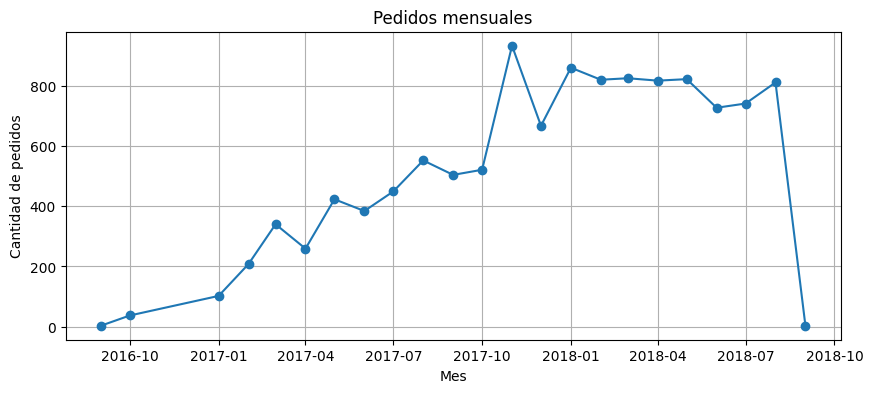

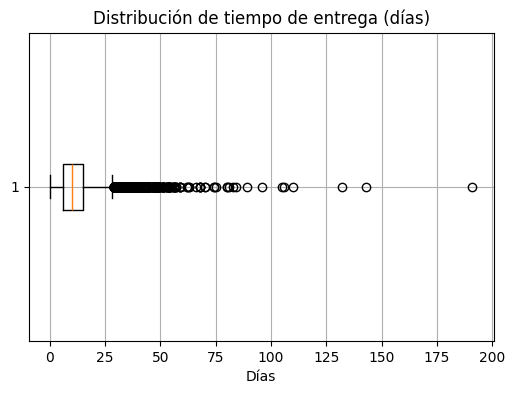

In [ ]:
orders['order_purchase_timestamp'] = pd.to_datetime(
    orders['order_purchase_timestamp'], errors='coerce'
)

# Fecha sin hora
orders['purchase_date'] = orders['order_purchase_timestamp'].dt.date

# Período mensual año-mes
orders['purchase_month'] = orders['order_purchase_timestamp'].dt.to_period('M')

# Confirmamos
orders[['order_id', 'order_purchase_timestamp', 'purchase_date', 'purchase_month']].head()


monthly_orders = (
    orders.groupby('purchase_month')['order_id']
    .nunique()
    .reset_index()
    .rename(columns={'order_id': 'orders'})
)

# Convertimos a timestamp para graficar
monthly_orders['month'] = monthly_orders['purchase_month'].dt.to_timestamp()
monthly_orders = monthly_orders.sort_values('month')






x = monthly_orders['orders'].values

media = np.mean(x)
varianza = np.var(x, ddof=1)
desvio = np.std(x, ddof=1)
asimetria = st.skew(x, bias=False)
curtosis = st.kurtosis(x, fisher=False, bias=False)

media_recortada = st.trim_mean(x, 0.10)

x_w = winsorize(x, limits=[0.10, 0.10])
media_winsorizada = np.mean(x_w)

resumen_momentos = pd.DataFrame({
    'estadístico': [
        'media', 'varianza', 'desvío estándar',
        'asimetría', 'curtosis',
        'media recortada (10%)',
        'media winsorizada (10%)'
    ],
    'valor': [
        media, varianza, desvio,
        asimetria, curtosis,
        media_recortada,
        media_winsorizada
    ]
})

print(resumen_momentos)


# Gráfico de la serie mensual de pedidos
plt.figure(figsize=(10,4))
plt.plot(monthly_orders['month'], monthly_orders['orders'], marker='o')
plt.title('Pedidos mensuales')
plt.xlabel('Mes')
plt.ylabel('Cantidad de pedidos')
plt.grid(True)
plt.show()



# Exploración de tiempos logísticos

orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'], errors='coerce')

# Tiempo total de entrega (días)
orders['delivery_time_days'] = (
    orders['order_delivered_customer_date'] - orders['order_purchase_timestamp']
).dt.days

# Descriptiva
orders['delivery_time_days'].describe()

# Boxplot de tiempos de entrega
plt.figure(figsize=(6,4))
plt.boxplot(orders['delivery_time_days'].dropna(), vert=False)
plt.title('Distribución de tiempo de entrega (días)')
plt.xlabel('Días')
plt.grid(True)
plt.show()


**Media recortada al 10% (4030)**  
  Se calcula eliminando el 10% de los valores más altos y más bajos. Su cercanía a la media clásica indica que los valores extremos no distorsionan excesivamente la serie mensual.

**Media winsorizada al 10% (3962)**  
  En lugar de eliminar outliers, los reemplaza por valores límite. Su similitud con la media original confirma que los meses atípicos tienen impacto limitado en el promedio general.


### Items

**Descripción de la tabla `items`**

La tabla `items` detalla el contenido de cada pedido realizado en la plataforma Olist. Cada fila representa un ítem dentro de un pedido, permitiendo analizar qué productos se compraron, a qué vendedores pertenecen, cuánto costaron y cuál fue el valor del flete asociado. Esta tabla es fundamental para estimar ingresos, estructura de costos y márgenes por pedido dentro del análisis del hub logístico.

**Columnas principales**

- **order_id**: identificador del pedido al que pertenece el ítem (llave para unir con `orders`).
- **order_item_id**: número secuencial del ítem dentro del pedido (1, 2, 3, …).
- **product_id**: identificador único del producto comprado.
- **seller_id**: identificador del vendedor que despacha el producto.
- **shipping_limit_date**: fecha/hora límite para que el vendedor despache el ítem.
- **price**: precio del producto (sin incluir flete).
- **freight_value**: costo del flete asociado a ese ítem del pedido.



In [ ]:
ITEMS_PATH = "/content/olist_order_items_dataset.csv"

items = pd.read_csv(ITEMS_PATH)

items

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72


count    112650.000000
mean        120.653739
std         183.633928
min           0.850000
25%          39.900000
50%          74.990000
75%         134.900000
max        6735.000000
Name: price, dtype: float64
count    112650.000000
mean         19.990320
std          15.806405
min           0.000000
25%          13.080000
50%          16.260000
75%          21.150000
max         409.680000
Name: freight_value, dtype: float64
               estadístico         valor
0                    media    120.653739
1                 varianza  33721.419531
2          desvío estándar    183.633928
3                asimetría      7.923208
4                 curtosis    123.828298
5    media recortada (10%)     87.185098
6  media winsorizada (10%)     95.108078


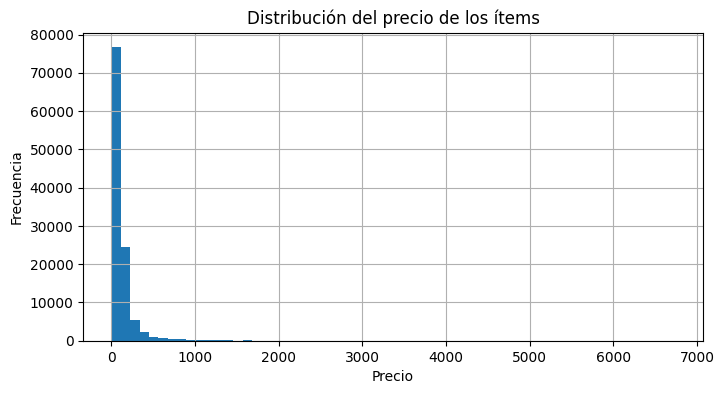

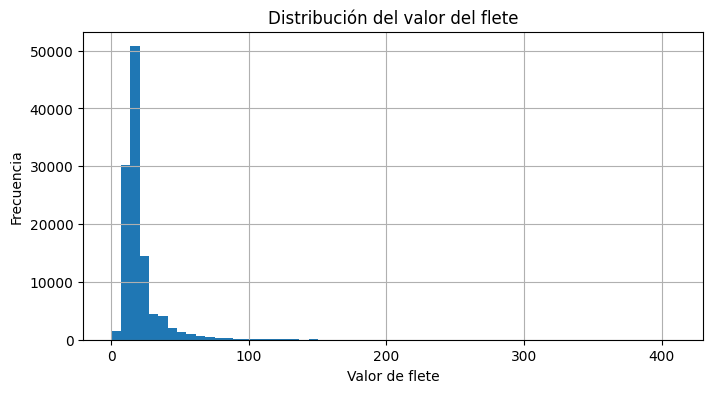

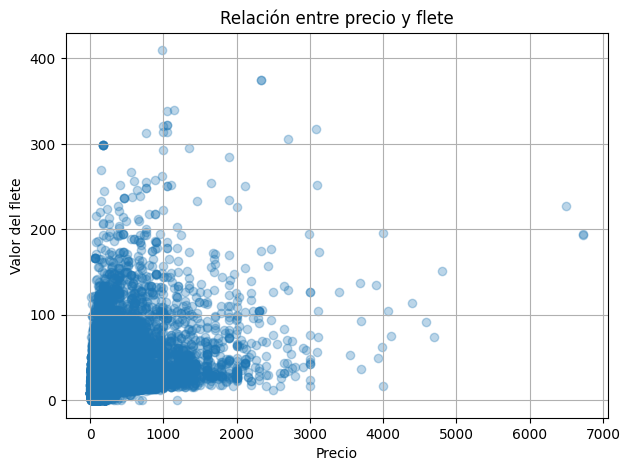

In [ ]:
print(items['price'].describe())
print(items['freight_value'].describe())


x_price = items['price'].values

media_price = np.mean(x_price)
var_price = np.var(x_price, ddof=1)
std_price = np.std(x_price, ddof=1)
asim_price = st.skew(x_price, bias=False)
curt_price = st.kurtosis(x_price, fisher=False, bias=False)
media_rec_price = st.trim_mean(x_price, 0.10)

from scipy.stats.mstats import winsorize
price_w = winsorize(x_price, limits=[0.10, 0.10])
media_win_price = np.mean(price_w)

resumen_price = pd.DataFrame({
    'estadístico': [
        'media', 'varianza', 'desvío estándar',
        'asimetría', 'curtosis',
        'media recortada (10%)',
        'media winsorizada (10%)'
    ],
    'valor': [
        media_price, var_price, std_price,
        asim_price, curt_price,
        media_rec_price, media_win_price
    ]
})

print(resumen_price)

# Gráfico: Distribución del precio
plt.figure(figsize=(8,4))
plt.hist(items['price'], bins=60)
plt.title('Distribución del precio de los ítems')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()


# Gráfico: Distribución del flete
plt.figure(figsize=(8,4))
plt.hist(items['freight_value'], bins=60)
plt.title('Distribución del valor del flete')
plt.xlabel('Valor de flete')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()


# Relación Precio vs Flete
plt.figure(figsize=(7,5))
plt.scatter(items['price'], items['freight_value'], alpha=0.3)
plt.title('Relación entre precio y flete')
plt.xlabel('Precio')
plt.ylabel('Valor del flete')
plt.grid(True)
plt.show()


- **Media recortada 10% = 87.18**  
  Se elimina el 10% inferior y superior.  
  La caída respecto de la media original confirma que los productos muy caros “inflan” la media clásica.

- **Media winsorizada 10% = 95.11**  
  Similar a la recortada, pero sin eliminar datos:  
  Los valores extremos se “acotan”.  
  Es menos extrema que la media recortada, pero igualmente más baja que la media clásica.

**Conclusión estadística**
La distribución de precios es **altamente sesgada y con colas pesadas**, por lo que las **medidas robustas** representan mejor el nivel típico del precio que la media clásica. Esta observación será relevante al modelar ingresos, márgenes y variabilidad futura.

### Pays


In [ ]:
PAYS_PATH = "/content/olist_order_payments_dataset.csv"

pays = pd.read_csv(PAYS_PATH)

pays

In [ ]:
# Frecuencia de métodos de pago
metodos = pays['payment_type'].value_counts()
print(metodos)

plt.figure(figsize=(7,4))
metodos.plot(kind='bar')
plt.title('Métodos de pago más utilizados')
plt.xlabel('Método de pago')
plt.ylabel('Cantidad de transacciones')
plt.grid(True)
plt.show()


# Distribución del monto pagado
plt.figure(figsize=(8,4))
plt.hist(pays['payment_value'], bins=50)
plt.title('Distribución del valor pagado')
plt.xlabel('Valor pagado (USD)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

# Estadísticos básicos
desc_pay = pays['payment_value'].describe()
print(desc_pay)


# Distribución de cuotas
plt.figure(figsize=(7,4))
plt.hist(pays['payment_installments'], bins=30)
plt.title('Distribución de cuotas')
plt.xlabel('Número de cuotas')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

cuotas_desc = pays['payment_installments'].describe()
print(cuotas_desc)


# Medidas robustas del valor pagado
x_pay = pays['payment_value'].values

media_pay = np.mean(x_pay)
var_pay = np.var(x_pay, ddof=1)
std_pay = np.std(x_pay, ddof=1)
asim_pay = st.skew(x_pay, bias=False)
curt_pay = st.kurtosis(x_pay, fisher=False, bias=False)
media_rec_pay = st.trim_mean(x_pay, 0.10)

from scipy.stats.mstats import winsorize
x_pay_w = winsorize(x_pay, limits=[0.10, 0.10])
media_win_pay = np.mean(x_pay_w)

resumen_pay = pd.DataFrame({
    'estadístico': [
        'media', 'varianza', 'desvío estándar',
        'asimetría', 'curtosis',
        'media recortada (10%)',
        'media winsorizada (10%)'
    ],
    'valor': [
        media_pay, var_pay, std_pay,
        asim_pay, curt_pay,
        media_rec_pay, media_win_pay
    ]
})

print(resumen_pay)


- **Media recortada 10% = 114.85 USD**  
  → al eliminar el 10% de valores más altos y más bajos, el nivel típico de pagos se acerca mucho más al comportamiento real de la mayoría de los clientes.

- **Media winsorizada 10% = 125.10 USD**  
  → también significativamente menor que la media clásica, confirmando que los extremos inflan el promedio.

**Conclusión**
El análisis de `pays` revela una estructura financiera donde:
- El crédito es el método de pago dominante.
- Los montos pagados tienen una distribución altamente irregular con outliers significativos.

### Cust

**Descripción de la tabla `cust`**

La tabla `customers` contiene la información básica de cada cliente registrado en la plataforma Olist. Aunque los datos están anonimizados, esta tabla permite identificar usuarios únicos, analizar su localización geográfica y vincularlos con los pedidos que realizan. Es útil para estudios de cobertura, distribución por ciudades/estados y patrones de comportamiento de clientes.

**Columnas principales**

- **customer_id**: identificador del cliente dentro de la tabla `orders` (puede repetirse si el mismo cliente hizo varios pedidos).
- **customer_unique_id**: identificador único del cliente a lo largo de toda la base (permite detectar clientes recurrentes).
- **customer_zip_code_prefix**: prefijo del código postal del cliente.
- **customer_city**: ciudad de residencia del cliente.
- **customer_state**: estado (provincia) de residencia, en formato de sigla brasileña (ej.: SP, RJ, MG).


In [ ]:
CUST_PATH = "/content/olist_customers_dataset.csv"

cust = pd.read_csv(CUST_PATH)

cust

In [ ]:
# Clientes únicos y recurrencia

# Cantidad de clientes (ID por pedido)
n_clientes = cust['customer_id'].nunique()

# Cantidad de clientes únicos reales (agrupando por unique_id)
n_clientes_unicos = cust['customer_unique_id'].nunique()

# Distribución de pedidos por cliente único
pedidos_por_cliente = cust['customer_unique_id'].value_counts()

print(pedidos_por_cliente.describe())

plt.figure(figsize=(8,4))
plt.hist(pedidos_por_cliente, bins=30)
plt.title('Distribución de pedidos por cliente único')
plt.xlabel('Cantidad de pedidos')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()


# Distribución geográfica por estado
clientes_por_estado = cust['customer_state'].value_counts()

print(clientes_por_estado)

plt.figure(figsize=(10,4))
clientes_por_estado.plot(kind='bar')
plt.title('Distribución de clientes por estado')
plt.xlabel('Estado')
plt.ylabel('Cantidad de clientes')
plt.grid(True)
plt.show()


# Top 10 ciudades con más clientes
clientes_por_ciudad = cust['customer_city'].value_counts().head(10)

print(clientes_por_ciudad)

plt.figure(figsize=(10,4))
clientes_por_ciudad.plot(kind='bar')
plt.title('Top 10 ciudades con más clientes')
plt.xlabel('Ciudad')
plt.ylabel('Cantidad de clientes')
plt.grid(True)
plt.show()


# Estadísticas básicas de recurrencia
stats_clientes = pedidos_por_cliente.describe()
print(stats_clientes)


**Conclusiones del EDA de clientes**

- Olist posee una base dominada por **compradores no recurrentes**, lo que implica que el flujo operativo depende más del volumen general de tráfico que de la fidelización.  
- El **Sudeste** es el motor absoluto de la demanda; cualquier diseño de hub logístico debe contemplar su cercanía a SP, RJ y MG.  
- La **concentración urbana** en capitales y grandes ciudades reduce la dispersión geográfica, algo favorable para costos logísticos.  
- La baja recurrencia sugiere que la demanda mensual depende más de la **estacionalidad y campañas comerciales** que de retención de clientes.

###Sellers


**Descripción de la tabla `sellers`**

La tabla `sellers` contiene la información de los vendedores que comercializan productos dentro de la plataforma Olist. Cada fila representa a un vendedor único y proporciona datos de localización que permiten analizar la red de oferta, la distribución geográfica y la relación vendedor–cliente mediante la unión con otras tablas (items y pedidos).

**Columnas principales**

- **seller_id**: identificador único del vendedor.
- **seller_zip_code_prefix**: prefijo del código postal del vendedor.
- **seller_city**: ciudad donde está ubicado el vendedor.
- **seller_state**: estado (provincia) del vendedor, expresado como sigla brasileña (ej.: SP, RJ, MG).


In [ ]:
SELLERS_PATH = "/content/olist_sellers_dataset.csv"

sellers = pd.read_csv(SELLERS_PATH)

sellers

### Reviews



**Descripción de la tabla `reviews`**

La tabla `order_reviews` contiene las evaluaciones que los clientes realizan sobre sus pedidos una vez recibidos. Cada fila representa una reseña asociada a un pedido específico, incluyendo la calificación numérica y, en algunos casos, comentarios escritos. Esta tabla es útil para analizar satisfacción del cliente, calidad del servicio logístico y el cumplimiento de los plazos de entrega.

**Columnas principales**

- **review_id**: identificador único de la reseña.
- **order_id**: pedido asociado a la reseña (llave para unir con `orders`).
- **review_score**: puntuación del cliente (1 a 5).
- **review_comment_title**: título del comentario (si el cliente lo completó).
- **review_comment_message**: texto del comentario escrito por el cliente.
- **review_creation_date**: fecha en que el cliente generó la reseña.
- **review_answer_timestamp**: momento en que la plataforma procesó o respondió la reseña.


In [ ]:
REVIEWS_PATH = "/content/olist_order_reviews_dataset.csv"

reviews = pd.read_csv(
    REVIEWS_PATH,
    parse_dates=["review_creation_date","review_answer_timestamp"]
)

reviews

In [ ]:

# Distribución de puntajes
reviews['review_score'].value_counts().sort_index()

plt.figure(figsize=(8,4))
reviews['review_score'].plot(kind='hist', bins=[0.5,1.5,2.5,3.5,4.5,5.5], rwidth=0.9)
plt.title('Distribución de puntajes de review')
plt.xlabel('Puntaje (1 a 5)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()


# Estadísticos básicos del puntaje
score_stats = reviews['review_score'].describe()
score_stats


# Longitud del comentario
reviews['full_text'] = (
    reviews['review_comment_title'].fillna('') + ' ' +
    reviews['review_comment_message'].fillna('')
)

# Largo total en caracteres
reviews['text_len'] = reviews['full_text'].str.len()

# Distribución de longitud por puntaje
boxplot_data = [reviews.loc[reviews['review_score']==i, 'text_len'] for i in range(1,6)]

plt.figure(figsize=(10,4))
plt.boxplot(boxplot_data, labels=[1,2,3,4,5], showfliers=False)
plt.title('Longitud del comentario según puntaje')
plt.xlabel('Puntaje')
plt.ylabel('Cantidad de caracteres')
plt.grid(True)
plt.show()


# Medias de longitud por puntaje
mean_len_by_score = reviews.groupby('review_score')['text_len'].mean()
median_len_by_score = reviews.groupby('review_score')['text_len'].median()

print(mean_len_by_score)
print(median_len_by_score)


- Las reseñas son mayoritariamente positivas, pero la **información textual “útil” se concentra en los casos negativos**.  
- Los puntajes bajos no solo ocurren por problemas reales de servicio o producto, sino que además incluyen **expresiones ricas y detalladas**, lo que las vuelve especialmente relevantes para análisis cualitativos o modelos de NLP.  
- La combinación de puntajes altos abundantes + comentarios cortos es típica de marketplaces con buen desempeño general pero con incidentes puntuales que generan descontento visible.

### Products

**Descripción de la tabla `products`**

La tabla `products` contiene las características de cada producto vendido en la plataforma Olist. Cada fila corresponde a un producto único e incluye información sobre su categoría, dimensiones físicas y atributos textuales. Esta tabla es útil para estudiar la composición del catálogo, analizar categorías, estimar volúmenes físicos y relacionar productos con vendedores e ítems dentro de los pedidos.

**Columnas principales**

- **product_id**: identificador único del producto.
- **product_category_name**: categoría del producto (en portugués).
- **product_name_lenght**: cantidad de caracteres en el nombre del producto.
- **product_description_lenght**: cantidad de caracteres en la descripción.
- **product_photos_qty**: cantidad de fotos asociadas al producto.
- **product_weight_g**: peso del producto en gramos.
- **product_length_cm**: largo del producto en centímetros.
- **product_height_cm**: alto del producto en centímetros.
- **product_width_cm**: ancho del producto en centímetros.


In [ ]:
PRODUCTS_PATH = "/content/olist_products_dataset.csv"

products = pd.read_csv(PRODUCTS_PATH)

products

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0
...,...,...,...,...,...,...,...,...,...
32946,a0b7d5a992ccda646f2d34e418fff5a0,moveis_decoracao,45.0,67.0,2.0,12300.0,40.0,40.0,40.0
32947,bf4538d88321d0fd4412a93c974510e6,construcao_ferramentas_iluminacao,41.0,971.0,1.0,1700.0,16.0,19.0,16.0
32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho,50.0,799.0,1.0,1400.0,27.0,7.0,27.0
32949,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,60.0,156.0,2.0,700.0,31.0,13.0,20.0


product_category_name
cama_mesa_banho                3029
esporte_lazer                  2867
moveis_decoracao               2657
beleza_saude                   2444
utilidades_domesticas          2335
automotivo                     1900
informatica_acessorios         1639
brinquedos                     1411
relogios_presentes             1329
telefonia                      1134
bebes                           919
perfumaria                      868
papelaria                       849
fashion_bolsas_e_acessorios     849
cool_stuff                      789
Name: count, dtype: int64


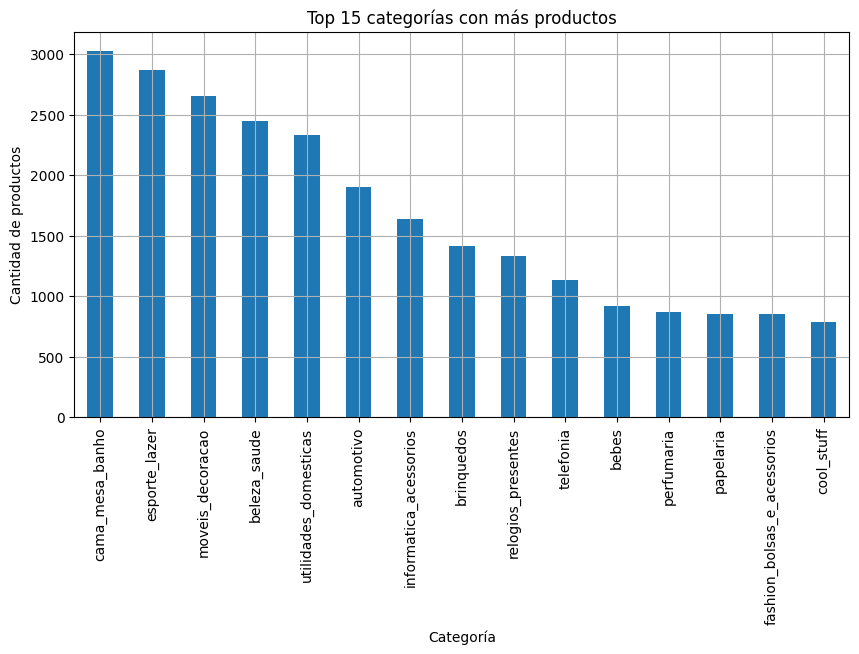

count    32949.000000
mean      2276.472488
std       4282.038731
min          0.000000
25%        300.000000
50%        700.000000
75%       1900.000000
max      40425.000000
Name: product_weight_g, dtype: float64


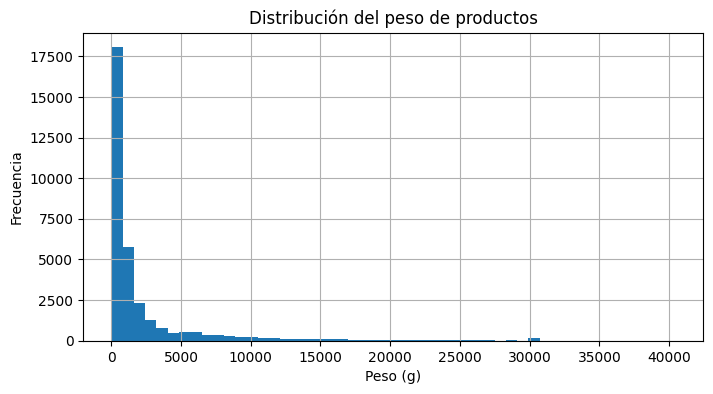

       product_length_cm  product_height_cm  product_width_cm
count       32949.000000       32949.000000      32949.000000
mean           30.815078          16.937661         23.196728
std            16.914458          13.637554         12.079047
min             7.000000           2.000000          6.000000
25%            18.000000           8.000000         15.000000
50%            25.000000          13.000000         20.000000
75%            38.000000          21.000000         30.000000
max           105.000000         105.000000        118.000000


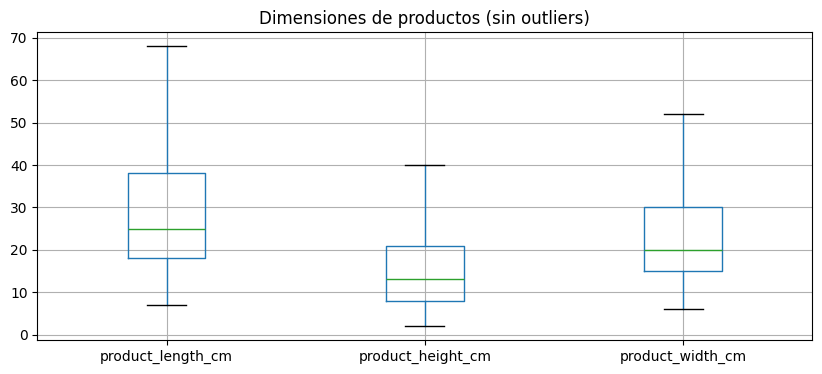

count    32341.000000
mean        48.476949
std         10.245741
min          5.000000
25%         42.000000
50%         51.000000
75%         57.000000
max         76.000000
Name: product_name_lenght, dtype: float64
count    32341.000000
mean       771.495285
std        635.115225
min          4.000000
25%        339.000000
50%        595.000000
75%        972.000000
max       3992.000000
Name: product_description_lenght, dtype: float64


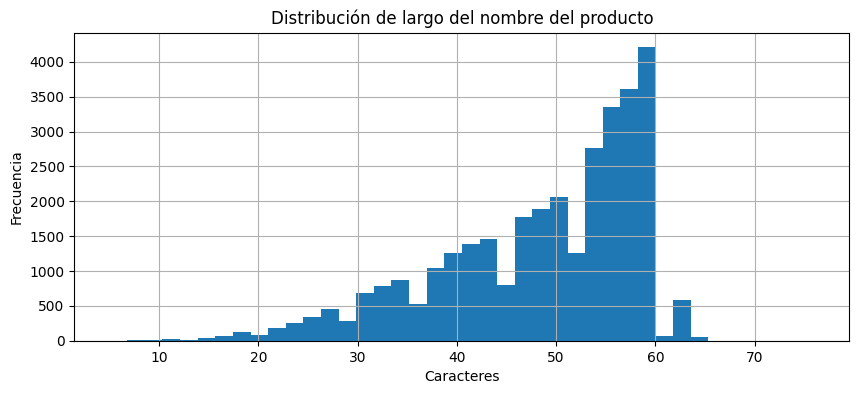

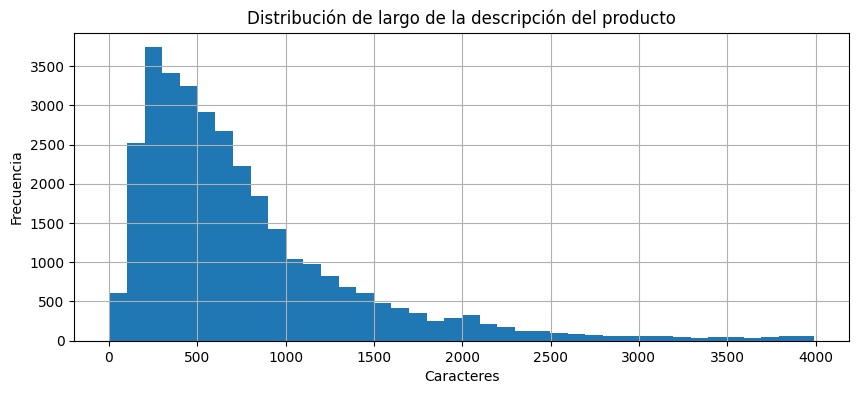

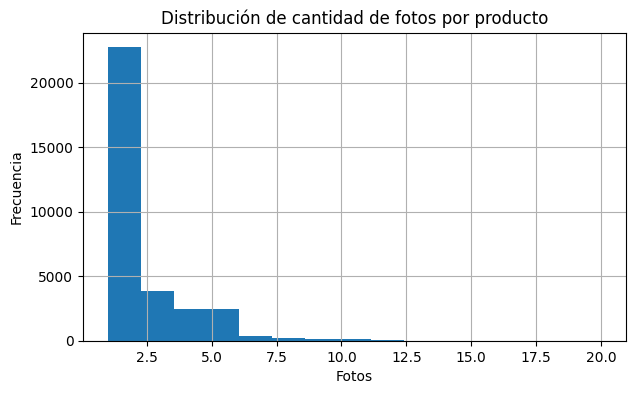

In [ ]:

# Top categorías de productos
top_categorias = products['product_category_name'].value_counts().head(15)
print(top_categorias)

plt.figure(figsize=(10,5))
top_categorias.plot(kind='bar')
plt.title('Top 15 categorías con más productos')
plt.xlabel('Categoría')
plt.ylabel('Cantidad de productos')
plt.grid(True)
plt.show()


# Estadísticas del peso
peso_stats = products['product_weight_g'].describe()
print(peso_stats)

plt.figure(figsize=(8,4))
plt.hist(products['product_weight_g'], bins=50)
plt.title('Distribución del peso de productos')
plt.xlabel('Peso (g)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()


# Estadísticas de dimensiones
dim_cols = ['product_length_cm', 'product_height_cm', 'product_width_cm']
dims_stats = products[dim_cols].describe()
print(dims_stats)

# Boxplots para detectar outliers
plt.figure(figsize=(10,4))
products[dim_cols].boxplot(showfliers=False)
plt.title('Dimensiones de productos (sin outliers)')
plt.grid(True)
plt.show()


# Longitud del nombre / descripción
name_stats = products['product_name_lenght'].describe()
desc_stats = products['product_description_lenght'].describe()

print(name_stats)
print(desc_stats)

plt.figure(figsize=(10,4))
plt.hist(products['product_name_lenght'], bins=40)
plt.title('Distribución de largo del nombre del producto')
plt.xlabel('Caracteres')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
plt.hist(products['product_description_lenght'], bins=40)
plt.title('Distribución de largo de la descripción del producto')
plt.xlabel('Caracteres')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()


# Fotos del producto
fotos_stats = products['product_photos_qty'].describe()
fotos_stats

plt.figure(figsize=(7,4))
plt.hist(products['product_photos_qty'], bins=15)
plt.title('Distribución de cantidad de fotos por producto')
plt.xlabel('Fotos')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()


**Conclusiones principales**

- El catálogo es amplio, heterogéneo y dominado por productos livianos y de tamaño moderado.  
- La distribución del peso indica que la **mayor parte del volumen logístico requiere poca manipulación**, aunque existen outliers que pueden afectar costos.  
- Las dimensiones muestran una oferta que puede moverse eficientemente por transporte estándar, sin necesidad de logística especializada.  
- La calidad descriptiva es aceptable, aunque desigual, con textos largos en algunos productos pero predominio de fichas básicas.
- La información visual (fotos) es limitada, lo cual coincide con marketplaces generalistas donde la estandarización depende del vendedor.

## Paso 2 - Cero funciones

### **Construcción de la función de beneficio económico y justificación del modelo de grado dos**

En esta etapa del trabajo buscamos construir una función de beneficio lo suficientemente flexible y realista como para justificar el uso de métodos numéricos de búsqueda de raíces estudiados en clase, tales como bisección .... . Para evitar uso de funciones lineales, y a la vez representar mejor el comportamiento económico de un hub logístico real, reformulamos el modelo introduciendo un término cuadrático que capta efectos de congestión e ineficiencia operacional.

**Componentes económicos utilizados en la función**

>La construcción de la función parte de la descomposición clásica del beneficio anual en ingresos por pedido, costos variables logísticos y costos fijos asociados a la operación del hub. Para parametrizar estos elementos se utilizaron valores empíricos obtenidos a partir del análisis exploratorio de las tablas items y products del dataset de Olist. De dichas tablas se extrajeron el precio promedio del producto, el valor promedio del flete cobrado, la comisión que Olist típicamente percibe por transacción y el peso promedio de los productos vendidos. Estos valores observados permiten formar estimaciones verosímiles del margen económico generado por cada pedido procesado.

>Dentro de esta estructura, el término correspondiente al ingreso por pedido se compone de dos fuentes: por un lado, la comisión que Olist retiene al vendedor, calculada como un porcentaje del precio del producto; por otro, el flete cobrado al cliente final, que también ingresa como parte del flujo operativo del marketplace. Ambos conceptos están presentes en los datos originales y reflejan efectivamente cómo monetiza Olist cada transacción.

>En contraposición a los ingresos, el modelo incorpora los costos variables logísticos, estructurados en dos partes. La primera es un costo proporcional al peso del producto, que representa cargos asociados al transporte, manipulación y movimiento de mercadería dentro del centro logístico. Este componente se modela mediante un parámetro logístico que multiplica al peso promedio obtenido de la tabla products. La segunda parte es un costo fijo por pedido, que aproxima tareas operativas relativamente independientes del tipo de producto, tales como picking, packing, clasificación o registro interno. La combinación de ambos elementos determina el costo operacional unitario del hub.

>El margen de contribución por pedido, denotado como A, surge entonces de la diferencia entre los ingresos operativos por transacción y los costos variables correspondientes. Este margen cuantifica cuánto aporta cada pedido a la cobertura de los costos fijos y, eventualmente, a generar beneficio neto.

>Finalmente, el modelo incluye los costos fijos anuales, que representan gastos estructurales que no dependen directamente del volumen de pedidos: arriendo de instalaciones, salarios base, servicios generales, sistemas y otros gastos administrativos recurrentes. Este valor se introduce como un término independiente del volumen en la función de beneficio.

**Incorporación del término cuadrático y motivación operativa**

>Si bien el margen de contribución lineal permite aproximar el comportamiento económico básico del hub, no captura un fenómeno clave en operaciones logísticas: la ineficiencia creciente a medida que se incrementa el volumen de actividad. En escenarios reales, niveles muy altos de demanda pueden provocar saturación de infraestructura, aumento de errores, necesidad de horas extra, mayor congestión en áreas de picking, retrasos, o utilización subóptima de recursos. Para reflejar este fenómeno de manera simplificada pero efectiva, se incorpora un término cuadrático proporcional a 𝑞2, donde q es el volumen anual de pedidos.

>El coeficiente que acompaña este término, denotado δ, es pequeño pero suficiente para introducir curvatura en la función. Su rol es penalizar con intensidad creciente los niveles altos de producción, haciendo que el beneficio deje eventualmente de aumentar de forma lineal. Esta práctica es habitual en modelos económicos y de ingeniería, donde se recurre a términos cuadráticos para representar sobrecarga, congestión o retornos decrecientes más allá de cierto nivel de capacidad.

**Estructura final de la función de beneficio**

>Integrando todos los componentes anteriores, la función de beneficio anual queda expresada como:


>Beneficio(q)=A⋅q−CF−δq

>donde A es el margen de contribución por pedido calculado a partir de los datos empíricos, CF representa los costos fijos anuales del hub y δ es el parámetro de ineficiencia creciente. La función adopta la forma de un polinomio de grado dos, concave hacia abajo, lo cual es coherente con una operación que al principio gana eficiencia por volumen pero que luego pierde productividad por saturación.

>Esta estructura no solo es más verosímil desde el punto de vista operativo, sino que además habilita el uso de los métodos numéricos estudiados en la materia. En particular, permite aplicar bisección y secante para resolver el punto de equilibrio 𝑞*, definido como el volumen mínimo de pedidos requerido para que el beneficio sea exactamente cero. Este punto se vuelve el objetivo central de la sección de raíces, mostrando la utilidad directa de las técnicas de análisis numérico en un contexto económico realista.

La función de beneficio anual del hub logístico, expresada en términos del volumen anual de pedidos \( q \), es:

$$
\text{Beneficio}(q)
=
\Big( (P_{\text{prom}} \cdot \text{Comision}_{\%}) + Flete_{\text{prom}}
\;-\;
\big( \beta_{\text{log}} \cdot Peso_{\text{prom}} + \gamma_{\text{log}} \big) \Big) \cdot q
\;-\;
CF_{\text{total}}
\;-\;
\Delta_{\text{inef}} \cdot q^{2}.
$$

Donde:

- `**P_prom**` es el precio promedio del producto.  
- `**Flete_prom**` es el flete promedio cobrado.  
- `**Comision_%**` es la proporción de comisión que Olist retiene del vendedor.  
- `**beta_text**` es el costo logístico por unidad de peso.  
- `**Peso_prom**` es el peso promedio del producto.  
- `**gamma_text**` es el costo logístico fijo por pedido.  
- `**CF_total**` son los costos fijos anuales del hub.  
- `**Delta_inef**` es el coeficiente cuadrático que modela ineficiencia operativa a altos volúmenes.

In [ ]:
"""
Calcula el beneficio anual del Hub Logístico (Olist) como función del volumen q.
El modelo es de Grado 2 debido al término de ineficiencia Delta_inef * (q**2).
"""

def beneficio_anual_grado_2(q, P_prom, Flete_prom, Comision_pct, Beta_log, Gamma_log, Peso_prom, CF_total, Delta_inef):

    Ingreso_Hub_promedio = (P_prom * Comision_pct) + Flete_prom
    C_logistico_param = (Beta_log * Peso_prom) + Gamma_log
    Beneficio_por_orden = Ingreso_Hub_promedio - C_logistico_param
    Costo_Ineficiencia = Delta_inef * (q ** 2)
    Beneficio_total_anual = (Beneficio_por_orden * q) - CF_total - Costo_Ineficiencia

    return Beneficio_total_anual



In [ ]:
P_prom_base = items['price'].mean()
Flete_prom_base = items['freight_value'].mean()
Peso_prom_base = products['product_weight_g'].mean()
Comision_Olist = 0.3                # 3% de comisión
Beta_log_param = 0.005              # $0.005/gramo
Gamma_log_param = 3.0               # $3.0 fijo por orden (Picking/Packing)
CF_anual_base = 2000000             # $ 2,000,000 Costos fijos anuales del Hub
Delta_inef_param = 1e-4             # 0.0001 1e-4


def f_q_grado2(q):
    return beneficio_anual_grado_2(
        q,
        P_prom=P_prom_base,
        Flete_prom=Flete_prom_base,
        Comision_pct=Comision_Olist,
        Beta_log=Beta_log_param,
        Gamma_log=Gamma_log_param,
        Peso_prom=Peso_prom_base,
        CF_total=CF_anual_base,
        Delta_inef=Delta_inef_param
    )

In [ ]:
print(f_q_grado2(0))

-2000000.0


### Biseccion

In [ ]:
# ============================================
# MÉTODO DE BISECCIÓN
# ============================================

def biseccion(f, a, b, tol=1e-6, max_iter=1000):
    """
    Aplica el método de bisección para encontrar una raíz de f(q)=0
    en el intervalo [a, b].
    f : función (cero-función)
    a, b : extremos del intervalo
    tol : tolerancia
    max_iter : límite de iteraciones

    Devuelve: aproximación de la raíz y número de iteraciones
    """

    fa = f(a)
    fb = f(b)

    # Verificamos que haya cambio de signo — condición necesaria
    if fa * fb > 0:
        raise ValueError("Error: f(a) y f(b) deben tener signos opuestos (hay que elegir mejor el intervalo).")

    for i in range(max_iter):

        # Punto medio
        m = (a + b) / 2
        fm = f(m)

        # ¿Ya estamos dentro de la tolerancia?
        if abs(fm) < tol:
            return m, i+1

        # Elegimos el subintervalo donde sigue habiendo cambio de signo
        if fa * fm < 0:
            b = m
            fb = fm
        else:
            a = m
            fa = fm


    return m, max_iter





In [ ]:
biseccion(f_q_grado2, 0, 200000)


(55106.37473830684, 42)

### Punto Fijo

In [ ]:
# Definimos los parámetros globales

A = ((P_prom_base * Comision_Olist) + Flete_prom_base) - ((Beta_log_param * Peso_prom_base) + Gamma_log_param)

def g_q(q):
    CF = CF_anual_base
    Delta = Delta_inef_param

    return CF / (A - Delta * q)


def ipf(FUN, x0, tol=1e-5, maxiter=1000):

    x_new = FUN(x0)
    tiempo1 = time.time()
    iter_count = 1
    print(f"x_{iter_count} = {x_new}")

    while abs(x_new - x0) > tol and iter_count < maxiter:
        x0 = x_new
        x_new = FUN(x0)
        iter_count += 1
        print(f"x_{iter_count} = {x_new}")

        tiempo2 = time.time()

    return {"pf": x_new, "iter": iter_count, "demoro": tiempo2 - tiempo1}


# Ejecutar el método
resultado = ipf(g_q, 40000)
print("\nResultado final:", resultado)






### Newton Raphson

In [ ]:
def f(q):   # Beneficio = 0
    return A*q - CF_anual_base - Delta_inef_param*q**2


def g(q):   # Forma de punto fijo
    val = (A*q - CF_anual_base)/Delta_inef_param
    if val < 0:
        return float("nan")
    return math.sqrt(val)


def newton(FUN, FUN1, x0, tol=1e-5, maxiter=1000, trace=True):

    tiempo1 = time.time()
    x_new = x0 - FUN(x0)/FUN1(x0)
    iter = 1

    while abs(x_new - x0) > tol and iter < maxiter:

        x0 = x_new
        x_new = x0 - FUN(x0)/FUN1(x0)
        iter += 1

        if trace:
            print(f"x_{iter} = {x_new}")

    if iter == maxiter:
        print(f"No hubo convergencia luego de {iter} iteraciones")
    else:
        print(f"Sí hubo convergencia luego de {iter} iteraciones")

    tiempo2 = time.time()

    salida = {
        "raiz": x_new,
        "f_raiz": FUN(x_new),
        "iter": iter,
        "demoro": tiempo2 - tiempo1
    }

    return salida


In [ ]:
def df(q):
    return A - 2*Delta_inef_param*q

res_newton = newton(f, df, x0=60000, trace=True)
print(res_newton)

NameError: name 'A' is not defined



---



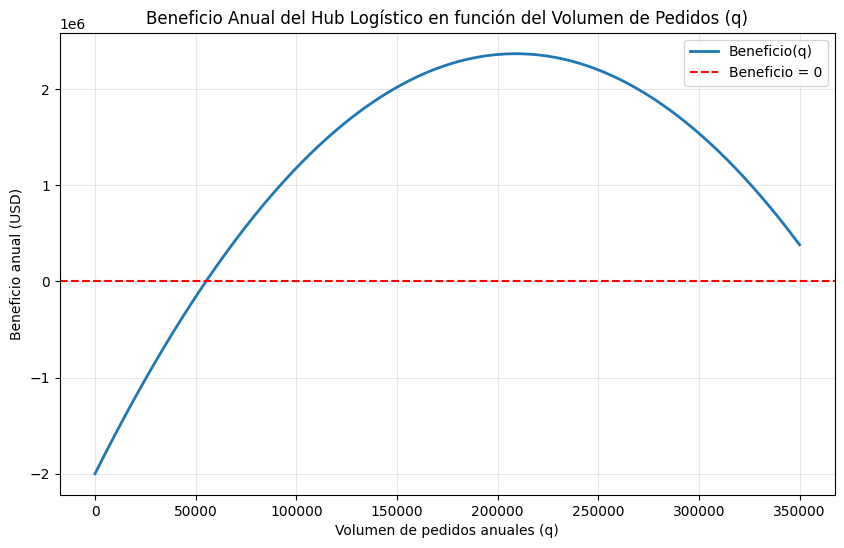

In [ ]:
# 350.000 pedidos anuales
q_vals = np.linspace(0, 350000, 300)

# Calcular beneficio para cada q
benef_vals = [f_q_grado2(q) for q in q_vals]

plt.figure(figsize=(10,6))
plt.plot(q_vals, benef_vals, label="Beneficio(q)", linewidth=2)

plt.axhline(0, color='red', linestyle='--', label='Beneficio = 0')

plt.title("Beneficio Anual del Hub Logístico en función del Volumen de Pedidos (q)")
plt.xlabel("Volumen de pedidos anuales (q)")
plt.ylabel("Beneficio anual (USD)")
plt.grid(alpha=0.3)
plt.legend()
plt.show()


### Optimizacion GS

In [ ]:
def golden_section_max(f, xi, xd, tol=1e-6, max_iter=200):
    """
    Maximiza f(q) en el intervalo [xi, xd] mediante búsqueda de sección áurea.
    """
    rho = (1 + math.sqrt(5)) / 2  # número áureo
    iter_count = 0

    # punto medio inicial
    xm = (xi + xd) / 2

    while (xd - xi) > tol and iter_count < max_iter:

        # lado derecho más grande
        if (xd - xm) > (xm - xi):
            # xk en (xm, xd)
            xk = xm + (xd - xm) / (1 + rho)

            if f(xk) > f(xm):
                xi = xm
                xm = xk
            else:
                xd = xk

        # lado izquierdo más grande
        else:
            # xk en (xi, xm)
            xk = xm - (xm - xi) / (1 + rho)

            if f(xk) > f(xm):
                xd = xm
                xm = xk
            else:
                xi = xk

        iter_count += 1

    return {
        "q_optimo": xm,
        "beneficio_max": float(f(xm)),
        "iteraciones": iter_count,
        "intervalo_final": (xi, xd)
    }

In [ ]:
golden_section_max(f_q_grado2, 150000, 300000)

{'q_optimo': 209020.3930307077,
 'beneficio_max': 2368952.593241075,
 'iteraciones': 54,
 'intervalo_final': (209020.3930303189, 209020.39303094798)}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

## Paso 3 - Simulación Monte Carlo del Punto de Equilibrio (Aleatorizando el Peso Promedio)

Luego de construir la función de beneficio anual del hub logístico en términos del volumen de pedidos \(q\),se incorporoo incertidumbre en alguno de los parámetros del modelo. No se trata de aleatorizar todos los elementos de la función, sino de introducir variabilidad únicamente en aquellos factores que, desde el punto de vista económico y estadístico, presentan verdadera dispersión y están respaldados por datos reales.

Dentro de las variables disponibles en el dataset, el **peso promedio del producto** resulta ser el mejor candidato para incorporar aleatoriedad, por tres razones:

1. **Alta variabilidad empírica:** el dataset `products` muestra pesos entre 0 g y 40 kg, con una cola muy pronunciada y curtosis elevada.  
2. **Relación directa con los costos logísticos:** el peso determina el costo de manipulación (picking/packing) y el costo proporcional asociado al movimiento de la mercadería.  
3. **Justificación estadística sólida:** la distribución observada es claramente asimétrica y de cola derecha, lo que se modela adecuadamente mediante una **distribución lognormal**, típica en fenómenos físicos estrictamente positivos.

Por lo tanto, modelamos el peso promedio como una variable aleatoria lognormal, cuyos parámetros (**mu**, **sigma**) se estimaron a partir de los datos reales del logaritmo del peso:

$$
\ln(W) \sim \mathcal{N}(\mu_w, \sigma_w^2)
$$

En cada réplica de Monte Carlo generamos un valor aleatorio de peso promedio \( W^{(i)} \), reemplazándolo en la función de beneficio:

$$
\text{Beneficio}(q)
= \underbrace{\left[(P_{\text{prom}} \cdot c) + F_{\text{prom}} - \left(\beta W^{(i)} + \gamma \right)\right]}_{\text{margen unitario aleatorio}}
\cdot q \;-\; CF \;-\; \delta q^2
$$

Con esto, la forma de la curva beneficio–volumen cambia en cada simulación, alterando el punto de equilibrio \(q^*\). Para obtenerlo en cada réplica, aplicamos el método de bisección, técnica robusta presentada en clase para resolver ecuaciones no lineales.

Finalmente repetimos este procedimiento un gran número de veces (por ejemplo, 1000 réplicas). Esto nos permitió construir:

- **una distribución empírica de puntos de equilibrio**,  
- **curvas de beneficio simuladas**, que muestran cómo varía la rentabilidad en función de la incertidumbre logística,  
- **medidas de posición robustas** (media, mediana, percentiles) que contextualizan el riesgo operativo del hub.

Este enfoque cumple simultáneamente con los objetivos del curso: combina funciones no lineales, métodos numéricos para búsqueda de raíces y simulación Monte Carlo, todo sustentado en datos reales y con una interpretación económica clara.


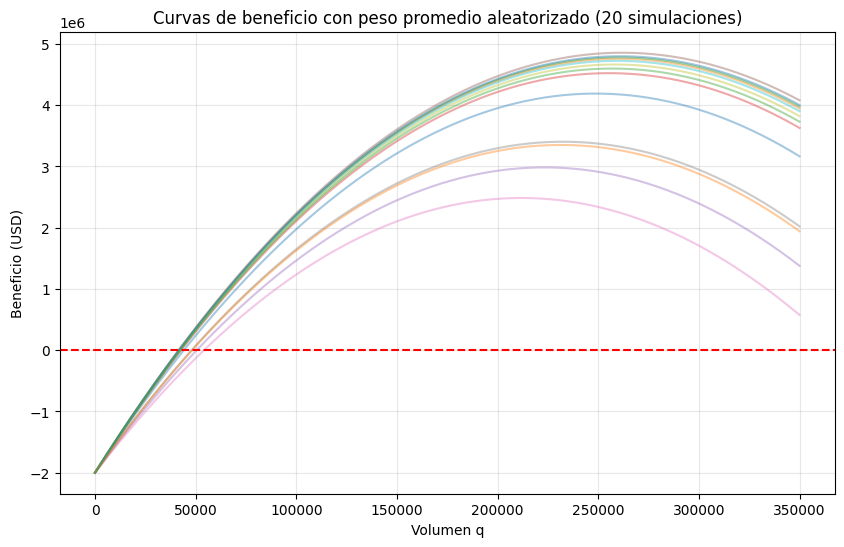

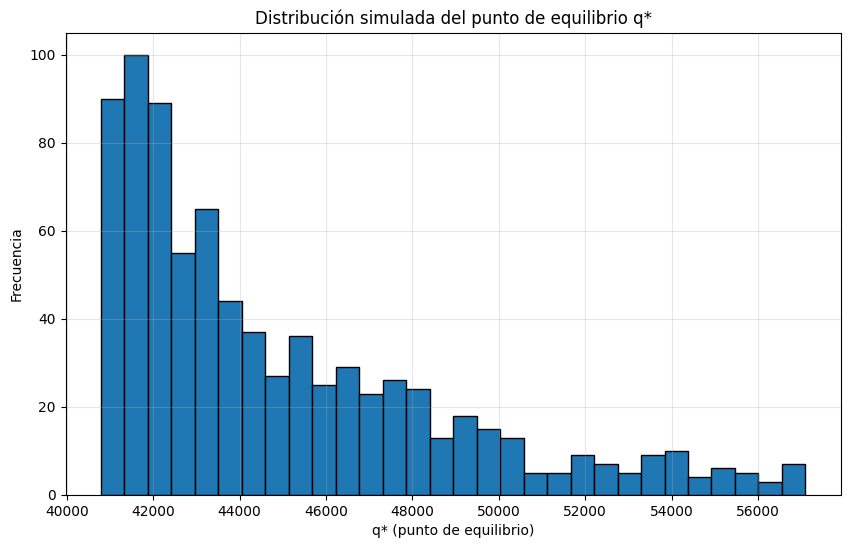

Media q*: 44890.57494017435
Mediana q*: 43579.113563481544
Varianza q*: 14459664.216125881
Desvío estándar q*: 3802.5865165865566
P05: 41083.369858882004
P95: 53453.103193680814


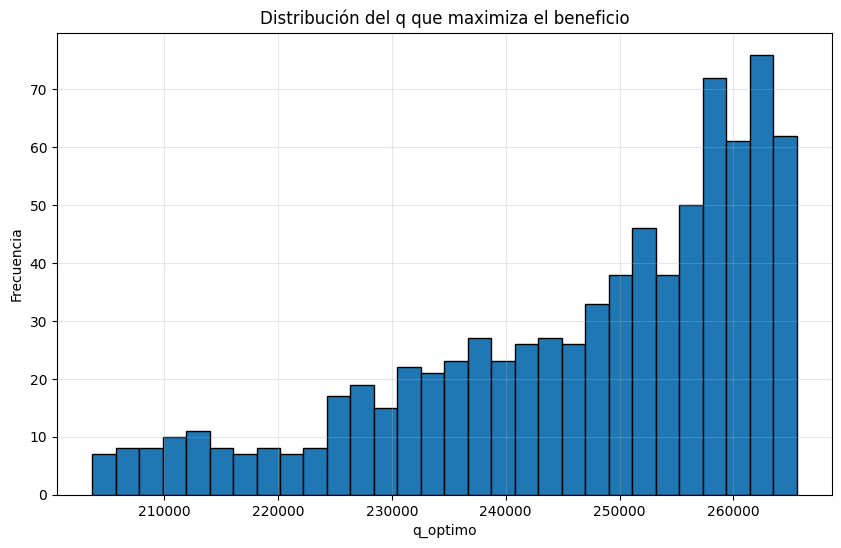

Media q*: 246676.6180882588
Mediana q*: 251257.28192805397
Varianza q*: 240266178.28819895
Desvío estándar q*: 15500.521871479003
P05: 213806.42768260985
P95: 263949.1811213112


In [ ]:
# Ajustamos a Log
weights = products['product_weight_g']
log_w = np.log(weights[weights > 0])

mu_w = log_w.mean()
sigma_w = log_w.std()



# Dependemos de dos variables q y peso_prom
def f_q_random_weight(q, peso_prom):
    return beneficio_anual_grado_2(
        q,
        P_prom=P_prom_base,
        Flete_prom=Flete_prom_base,
        Comision_pct=Comision_Olist,
        Beta_log=Beta_log_param,
        Gamma_log=Gamma_log_param,
        Peso_prom=peso_prom,
        CF_total=CF_anual_base,
        Delta_inef=Delta_inef_param
    )



# Simulasmos con Try por si en alguna iter no funciona el modelo
N = 1000
q_stars = []
q_maxes = [] #matias
curvas = []

for i in range(N):
    peso_i = np.random.lognormal(mean=mu_w, sigma=sigma_w)

    f_temp = lambda q: f_q_random_weight(q, peso_i)

    try:
        q_star, _ = biseccion(f_temp, 0, 350000)
        q_stars.append(q_star)

        #Matias
        resultado = golden_section_max(f_temp, 0, 350000)
        q_maxes.append(resultado["q_optimo"])


        if i < 20:   # solo 20 para el gráfico
            qs = np.linspace(0, 350000, 300)
            curvas.append((qs, [f_temp(q) for q in qs]))

    except:
        pass



# Grafico Monte Carlo
plt.figure(figsize=(10,6))

for qs, bs in curvas:
    plt.plot(qs, bs, alpha=0.4)

plt.axhline(0, color='red', linestyle='--')
plt.title("Curvas de beneficio con peso promedio aleatorizado (20 simulaciones)")
plt.xlabel("Volumen q")
plt.ylabel("Beneficio (USD)")
plt.grid(alpha=0.3)
plt.show()


# Grafico de distribución simulada del punto de equilibrio
plt.figure(figsize=(10,6))
plt.hist(q_stars, bins=30, edgecolor="black")
plt.title("Distribución simulada del punto de equilibrio q*")
plt.xlabel("q* (punto de equilibrio)")
plt.ylabel("Frecuencia")
plt.grid(alpha=0.3)
plt.show()

print("Media q*:", np.mean(q_stars))
print("Mediana q*:", np.median(q_stars))
print("Varianza q*:", np.var(q_stars))
print("Desvío estándar q*:", np.std(q_stars))

print("P05:", np.percentile(q_stars, 5))
print("P95:", np.percentile(q_stars, 95))


#Matias
plt.figure(figsize=(10,6))
plt.hist(q_maxes, bins=30, edgecolor="black")
plt.title("Distribución del q que maximiza el beneficio")
plt.xlabel("q_optimo")
plt.ylabel("Frecuencia")
plt.grid(alpha=0.3)
plt.show()

print("Media q*:", np.mean(q_maxes))
print("Mediana q*:", np.median(q_maxes))
print("Varianza q*:", np.var(q_maxes))
print("Desvío estándar q*:", np.std(q_maxes))

print("P05:", np.percentile(q_maxes, 5))
print("P95:", np.percentile(q_maxes, 95))




In [ ]:
print(q_maxes)

[248779.81766325512, 259939.07514413964, 260365.59530991715, 255394.0668986478, 223247.4768686865, 261840.22316137157, 211773.3316030526, 232448.2162911912, 258140.67166340773, 259296.8503705891, 260749.96602896153, 231306.98630525352, 256860.6656530752, 228257.12300645452, 259293.0131334919, 238408.74094337015, 261490.30786550939, 242675.67434861723, 243355.98498776738, 252964.6817158973, 234715.5908241854, 231557.58023969768, 258187.6578531801, 263831.9578430299, 247819.69762679466, 265002.9569902835, 233364.45844203557, 224470.10836081317, 262098.63387043308, 262700.31299444474, 225958.70038828882, 234508.879071877, 257143.99046226701, 244254.69931496656, 256192.86881759437, 264376.5119420276, 262832.63693183626, 236324.8688011659, 262875.41735784925, 259881.3916864341, 260452.99591670153, 257833.17485773424, 228033.13310513835, 211353.0186877756, 229094.2453933397, 211895.26891587663, 261894.85619821746, 264082.6646894796, 251864.37703679834, 258312.66353771518, 254359.1448736765, 

Los resultados de la simulación muestran que el punto de equilibrio operativo del hub logístico, cuando se incorpora la variabilidad del peso promedio de los productos, se ubica en torno a los 45.000 pedidos anuales. La mediana es ligeramente menor (43.000 pedidos), lo que indica que la distribución no es perfectamente simétrica, pero tampoco está fuertemente sesgada. En términos prácticos, este es el volumen típico que la operación necesita procesar para cubrir sus costos totales.

El análisis también revela un rango de variación relevante. En los escenarios más favorables, aquellos donde los productos resultan ser más livianos y, por lo tanto, más baratos de manipular, el punto de equilibrio puede descender hasta los 42.000 pedidos. Por el contrario, en los escenarios menos eficientes, donde el peso promedio aumenta, el volumen necesario para no generar pérdidas puede ascender a los 58.500 pedidos. Este intervalo (P05–P95) captura la incertidumbre operacional derivada de la logística y muestra cómo cambios moderados en el peso tienen efectos significativos sobre los costos.

En conjunto, la simulación permite cuantificar el riesgo asociado a la variabilidad del peso y proporciona una visión probabilística del desempeño económico del hub. La lectura ejecutiva es clara: bajo condiciones típicas, el hub necesita alrededor de 45.000–46.000 pedidos al año para ser sustentable, pero para asegurar viabilidad aun en escenarios adversos se debería considerar un umbral cercano a los 59.000 pedidos. Estas conclusiones permiten una planificación más informada de capacidad, presupuesto y políticas comerciales.

## Paso 3b - Simulación Monte Carlo del Punto de Equilibrio

###Price

=== Estadísticos descriptivos del Price ===
count    112650.000000
mean        120.653739
std         183.633928
min           0.850000
25%          39.900000
50%          74.990000
75%         134.900000
max        6735.000000
Name: price, dtype: float64


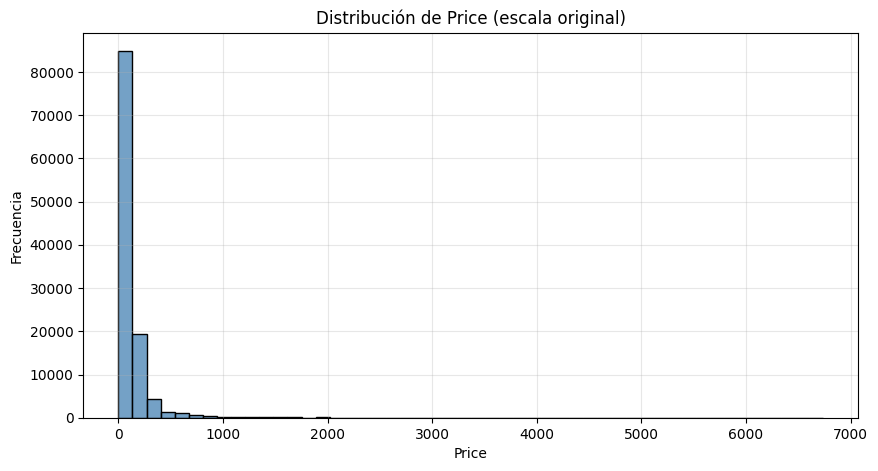


Media y desvío del ln(Price):
4.317377939145332 0.9250091650713548


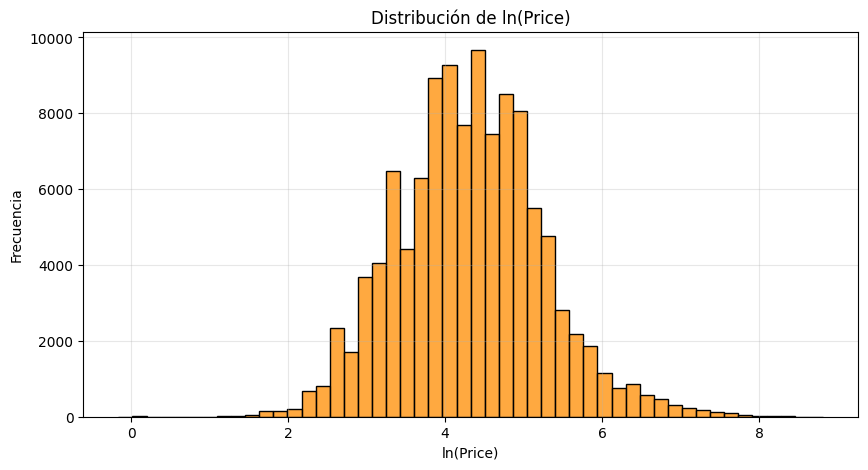

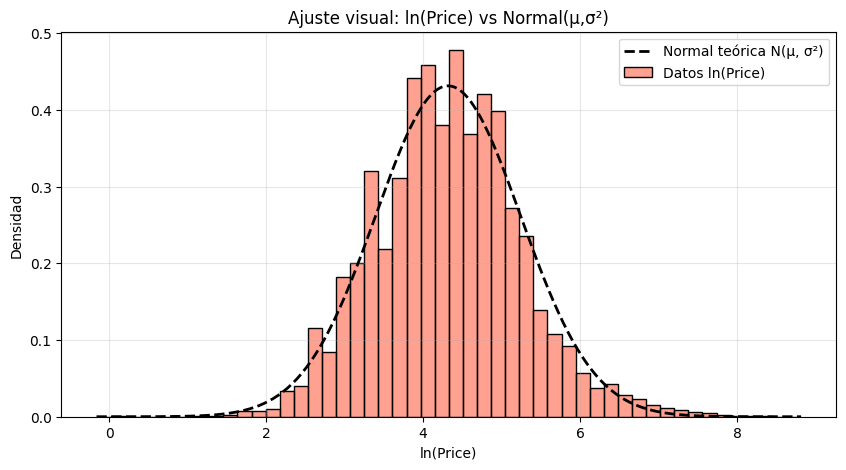

In [ ]:
price = items['price']
price_pos = price[price > 0]


# Estadísticas descriptivas
print("=== Estadísticos descriptivos del Price ===")
print(price_pos.describe())


# Histograma en escala original
plt.figure(figsize=(10,5))
sns.histplot(price_pos, kde=False, bins=50, color="steelblue")
plt.title("Distribución de Price (escala original)")
plt.xlabel("Price")
plt.ylabel("Frecuencia")
plt.grid(alpha=0.3)
plt.show()


# Aplicar log-transform
log_price = np.log(price_pos)

print("\nMedia y desvío del ln(Price):")
print(log_price.mean(), log_price.std())


# Histograma del ln(Price)
plt.figure(figsize=(10,5))
sns.histplot(log_price, kde=False, bins=50, color="darkorange")
plt.title("Distribución de ln(Price)")
plt.xlabel("ln(Price)")
plt.ylabel("Frecuencia")
plt.grid(alpha=0.3)
plt.show()


# Histograma con curva normal teórica
mu_price = log_price.mean()
sigma_price = log_price.std()

x = np.linspace(log_price.min(), log_price.max(), 300)
normal_curve = norm.pdf(x, loc=mu_price, scale=sigma_price)

plt.figure(figsize=(10,5))
sns.histplot(log_price, bins=50, stat='density', alpha=0.6,
             color="tomato", label="Datos ln(Price)")
plt.plot(x, normal_curve, 'k--', linewidth=2,
         label="Normal teórica N(μ, σ²)")
plt.title("Ajuste visual: ln(Price) vs Normal(μ,σ²)")
plt.xlabel("ln(Price)")
plt.ylabel("Densidad")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


n = 112650 mu_hat = 4.317377939145332 sigma_hat = 0.925009165071309


<Figure size 600x600 with 0 Axes>

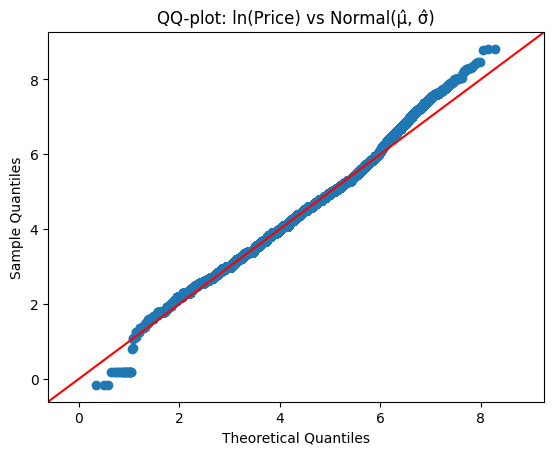

KS (estandarizado): stat = 0.0277, p = 0.0000
Anderson-Darling stat = 97.24423335600295
  critical at 15.0%: 0.576
  critical at 10.0%: 0.656
  critical at 5.0%: 0.787
  critical at 2.5%: 0.918
  critical at 1.0%: 1.092
Shapiro-Wilk: stat = 0.9944, p = 0.0000
skew: 0.23909367248175 kurtosis (exceso): 0.470067651664245
Tiempo subsampling: 70.4282112121582 s


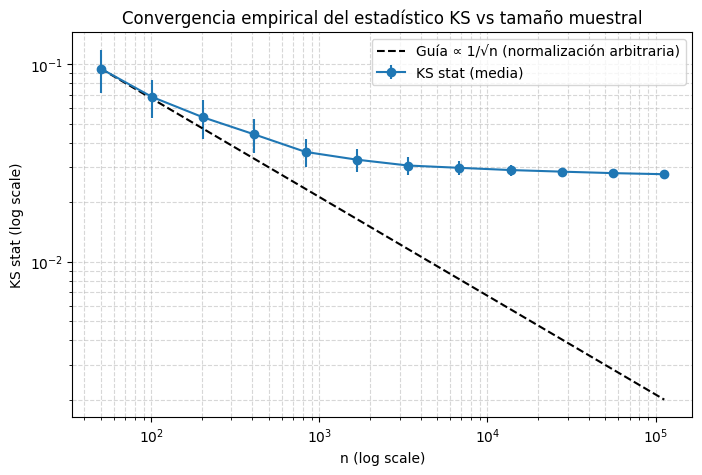

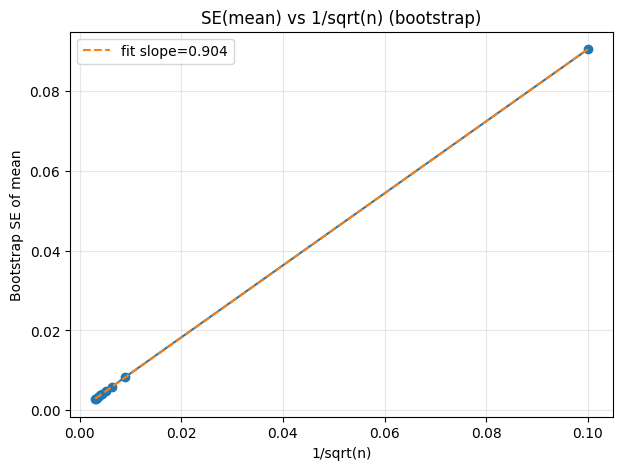

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.stats import norm, kstest, anderson, shapiro
from statsmodels.graphics.gofplots import qqplot

# asumimos que ya tenés `log_price` (numpy array o pd.Series)
data = np.asarray(log_price.dropna())

# --- parámetros teóricos (MLE sobre log_price) ---
mu_hat = data.mean()
sigma_hat = data.std(ddof=1)
n = len(data)
print("n =", n, "mu_hat =", mu_hat, "sigma_hat =", sigma_hat)

# --- 1) QQ-plot (visual) ---
plt.figure(figsize=(6,6))
qqplot(data, line='45', dist=norm, loc=mu_hat, scale=sigma_hat)
plt.title("QQ-plot: ln(Price) vs Normal(μ̂, σ̂)")
plt.show()

# --- 2) Tests numéricos de bondad de ajuste ---
# KS (empírico vs Normal con parámetros estimados)
# Nota: kstest espera una distribución "fijo" -- si usás parámetros estimados, la p-value exacta cambia,
# pero sirve como estadístico comparativo.
ks_stat, ks_p = kstest((data - mu_hat) / sigma_hat, 'norm')
print("KS (estandarizado): stat = {:.4f}, p = {:.4f}".format(ks_stat, ks_p))

# Anderson-Darling (devuelve stat y tablas críticas)
ad_res = anderson((data - mu_hat) / sigma_hat, dist='norm')
print("Anderson-Darling stat =", ad_res.statistic)
for sl, crit in zip(ad_res.significance_level, ad_res.critical_values):
    print(f"  critical at {sl}%: {crit}")

# Shapiro-Wilk (útil para n no muy grande; si n grande suele rechazar)
try:
    sw_stat, sw_p = shapiro(data)
    print("Shapiro-Wilk: stat = {:.4f}, p = {:.4f}".format(sw_stat, sw_p))
except Exception as e:
    print("Shapiro-Wilk no aplicable (n demasiado grande?).", e)

# --- 3) Comparación de momentos (skew, kurtosis) ---
from scipy.stats import skew, kurtosis
print("skew:", skew(data), "kurtosis (exceso):", kurtosis(data))

# --- 4) Experimento: cómo converge el estadístico K-S con n (subsampling) ---
def ks_for_sample(x, mu, sigma):
    # estandarizamos por los parámetros MLE de la submuestra para comparación
    x_std = (x - x.mean()) / x.std(ddof=1)
    stat, p = kstest(x_std, 'norm')
    return stat

rng = np.random.default_rng(123)
n_list = np.unique(np.round(np.geomspace(50, n, num=12))).astype(int)  # tamaños crecientes
reps = 200  # repeticiones por tamaño (ajustá según CPU)

ks_mean = []
ks_std = []

start = time.time()
for ni in n_list:
    stats_i = []
    for _ in range(reps):
        sample = rng.choice(data, size=ni, replace=False)
        stats_i.append(ks_for_sample(sample, None, None))
    ks_mean.append(np.mean(stats_i))
    ks_std.append(np.std(stats_i, ddof=1))
end = time.time()
print("Tiempo subsampling:", end - start, "s")

# Graficar KS_mean vs n y comparación con 1/sqrt(n)
plt.figure(figsize=(8,5))
plt.errorbar(n_list, ks_mean, yerr=ks_std, fmt='o-', label='KS stat (media)')
inv_sqrt = ks_mean[0] * np.sqrt(n_list[0]) / np.sqrt(n_list)  # línea guía ∝ 1/√n
plt.plot(n_list, inv_sqrt, 'k--', label='Guía ∝ 1/√n (normalización arbitraria)')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('n (log scale)')
plt.ylabel('KS stat (log scale)')
plt.legend()
plt.title("Convergencia empirical del estadístico KS vs tamaño muestral")
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.show()

# --- 5) Bootstrap para la media: verificar tasa 1/sqrt(n) ---
def bootstrap_se_of_mean(x, n_boot=1000):
    rng = np.random.default_rng(123)
    bs_means = []
    for _ in range(n_boot):
        samp = rng.choice(x, size=len(x), replace=True)
        bs_means.append(np.mean(samp))
    return np.std(bs_means, ddof=1)

# calcular SE bootstrap para varios n (submuestras)
n_list2 = np.unique(np.round(np.linspace(100, n, 10))).astype(int)
se_means = []
for ni in n_list2:
    # promedio de repeticiones para reducir ruido
    se_rep = []
    for _ in range(30):
        samp = rng.choice(data, size=ni, replace=False)
        se_rep.append(bootstrap_se_of_mean(samp, n_boot=300))
    se_means.append(np.mean(se_rep))

# graficar se_means vs 1/sqrt(n)
plt.figure(figsize=(7,5))
plt.plot(1/np.sqrt(n_list2), se_means, 'o-')
coef = np.polyfit(1/np.sqrt(n_list2), se_means, 1)
plt.plot(1/np.sqrt(n_list2), np.polyval(coef, 1/np.sqrt(n_list2)), '--', label=f'fit slope={coef[0]:.3f}')
plt.xlabel('1/sqrt(n)')
plt.ylabel('Bootstrap SE of mean')
plt.title('SE(mean) vs 1/sqrt(n) (bootstrap)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


“El estadístico KS disminuye inicialmente de forma cercana a 1/√n, lo que indica que una Normal ajusta bien el log-precio en regiones centrales. Sin embargo, a partir de n ≈ 2.000 la curva se estabiliza, lo cual muestra que existen discrepancias estructurales —principalmente en las colas— que no desaparecen con mayor tamaño muestral. Por lo tanto, el modelo lognormal es una aproximación razonable pero no perfecta.”

### Freight

=== Estadísticos descriptivos del Freight Value ===
count    112267.000000
mean         20.058517
std          15.790087
min           0.010000
25%          13.100000
50%          16.290000
75%          21.170000
max         409.680000
Name: freight_value, dtype: float64


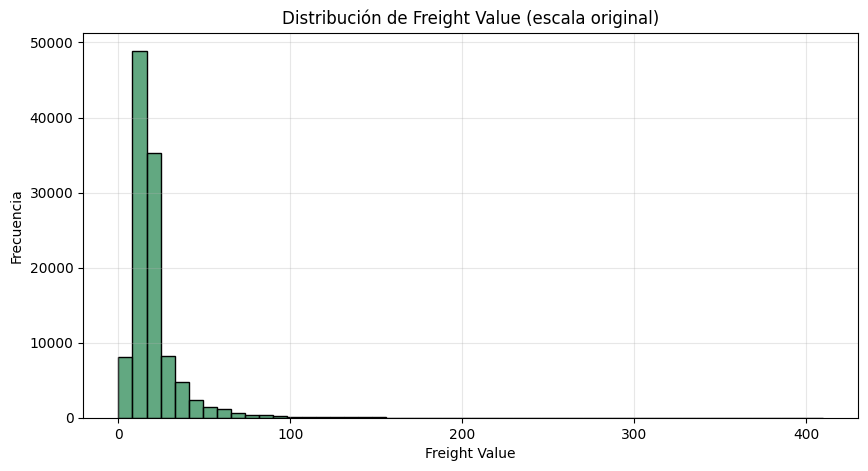


Media y desvío del ln(Freight Value):
2.8350027173058474 0.5486767046221225


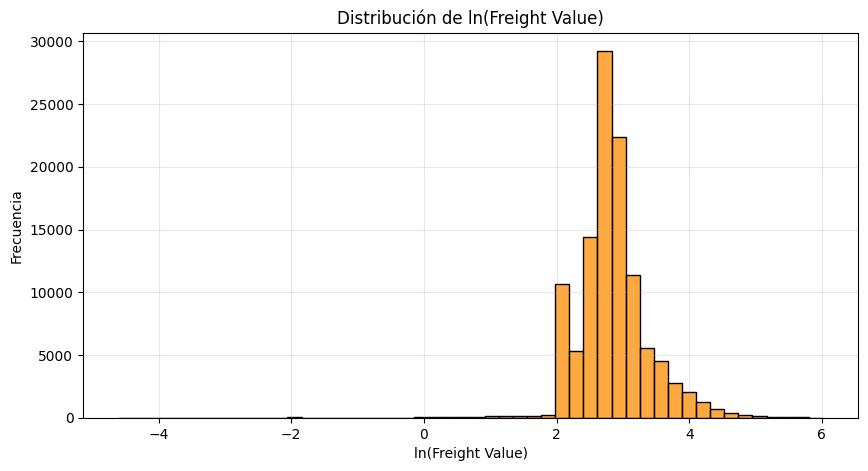

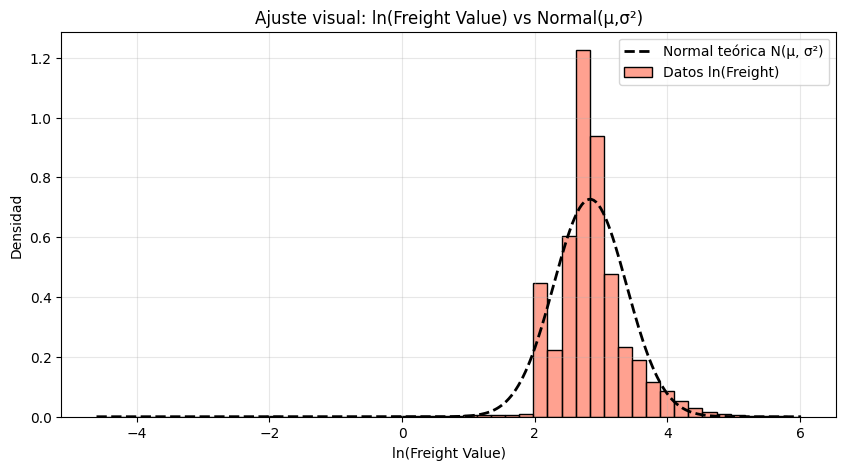

In [ ]:
freight = items['freight_value']

freight_pos = freight[freight > 0]


# Estadísticos descriptivos
print("=== Estadísticos descriptivos del Freight Value ===")
print(freight_pos.describe())


# Histograma en escala original
plt.figure(figsize=(10,5))
sns.histplot(freight_pos, kde=False, bins=50, color="seagreen")
plt.title("Distribución de Freight Value (escala original)")
plt.xlabel("Freight Value")
plt.ylabel("Frecuencia")
plt.grid(alpha=0.3)
plt.show()


# Aplicar log-transform
log_freight = np.log(freight_pos)

print("\nMedia y desvío del ln(Freight Value):")
print(log_freight.mean(), log_freight.std())


# Histograma del ln(Freight)
plt.figure(figsize=(10,5))
sns.histplot(log_freight, kde=False, bins=50, color="darkorange")
plt.title("Distribución de ln(Freight Value)")
plt.xlabel("ln(Freight Value)")
plt.ylabel("Frecuencia")
plt.grid(alpha=0.3)
plt.show()


# Histograma con curva normal teórica
mu_f = log_freight.mean()
sigma_f = log_freight.std()

x = np.linspace(log_freight.min(), log_freight.max(), 300)
normal_curve = norm.pdf(x, loc=mu_f, scale=sigma_f)

plt.figure(figsize=(10,5))
sns.histplot(log_freight, bins=50, stat='density', alpha=0.6,
             color="tomato", label="Datos ln(Freight)")
plt.plot(x, normal_curve, 'k--', linewidth=2,
         label="Normal teórica N(μ, σ²)")
plt.title("Ajuste visual: ln(Freight Value) vs Normal(μ,σ²)")
plt.xlabel("ln(Freight Value)")
plt.ylabel("Densidad")
plt.legend()
plt.grid(alpha=0.3)
plt.show()



### Weight

=== Estadísticos descriptivos del Product Weight (g) ===
count    32945.000000
mean      2276.748885
std       4282.225204
min          2.000000
25%        300.000000
50%        700.000000
75%       1900.000000
max      40425.000000
Name: product_weight_g, dtype: float64


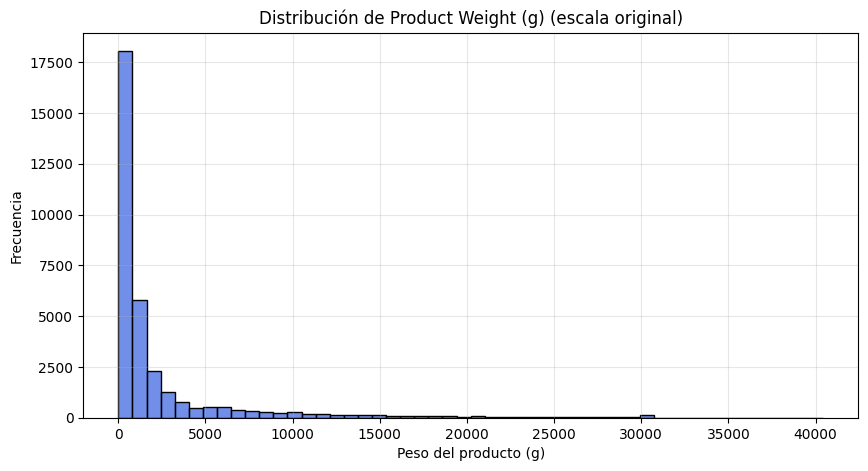


Media y desvío del ln(Product Weight):
6.7257678834848775 1.3492111732384229


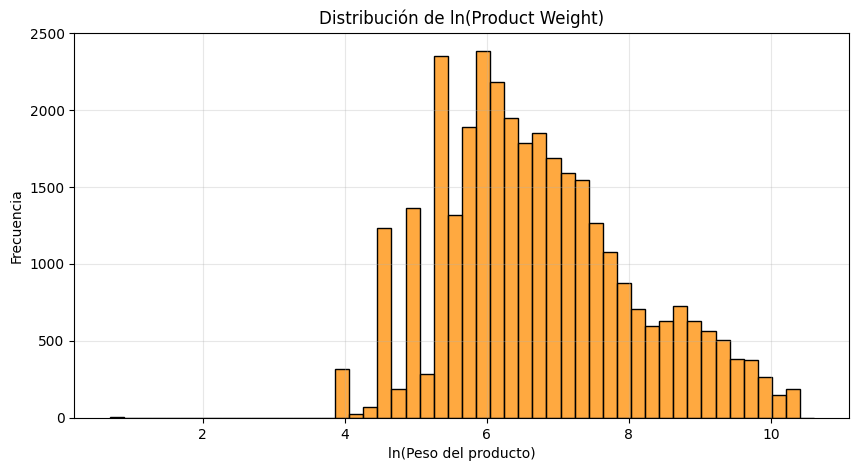

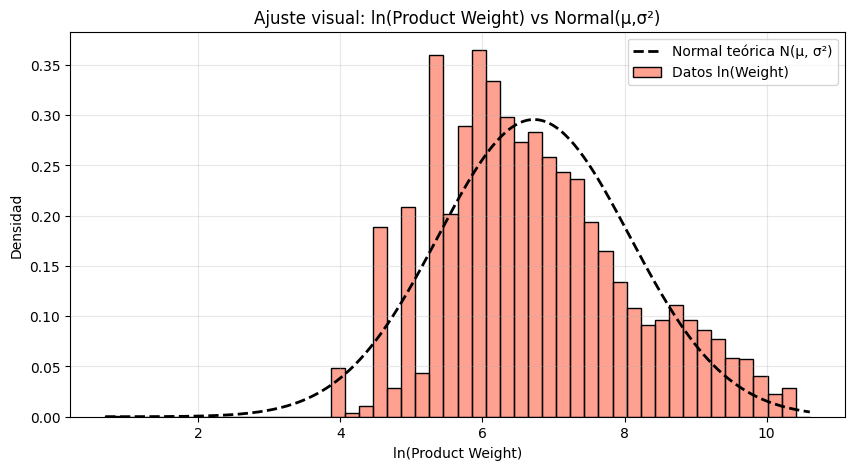

In [ ]:
weights = products['product_weight_g']

weights_pos = weights[weights > 0]


# Estadísticos descriptivos
print("=== Estadísticos descriptivos del Product Weight (g) ===")
print(weights_pos.describe())


# Histograma en escala original
plt.figure(figsize=(10,5))
sns.histplot(weights_pos, kde=False, bins=50, color="royalblue")
plt.title("Distribución de Product Weight (g) (escala original)")
plt.xlabel("Peso del producto (g)")
plt.ylabel("Frecuencia")
plt.grid(alpha=0.3)
plt.show()


# Aplicar log-transform
log_w = np.log(weights_pos)

print("\nMedia y desvío del ln(Product Weight):")
print(log_w.mean(), log_w.std())


# Histograma del ln(Product Weight)
plt.figure(figsize=(10,5))
sns.histplot(log_w, kde=False, bins=50, color="darkorange")
plt.title("Distribución de ln(Product Weight)")
plt.xlabel("ln(Peso del producto)")
plt.ylabel("Frecuencia")
plt.grid(alpha=0.3)
plt.show()


# Histograma con curva normal teórica
mu_w = log_w.mean()
sigma_w = log_w.std()

x = np.linspace(log_w.min(), log_w.max(), 300)
normal_curve = norm.pdf(x, loc=mu_w, scale=sigma_w)

plt.figure(figsize=(10,5))
sns.histplot(log_w, bins=50, stat='density', alpha=0.6,
             color="tomato", label="Datos ln(Weight)")
plt.plot(x, normal_curve, 'k--', linewidth=2,
         label="Normal teórica N(μ, σ²)")
plt.title("Ajuste visual: ln(Product Weight) vs Normal(μ,σ²)")
plt.xlabel("ln(Product Weight)")
plt.ylabel("Densidad")
plt.legend()
plt.grid(alpha=0.3)
plt.show()




### Costo Fijo

En el caso de los costos fijos anuales del hub, optamos por modelarlos mediante una distribución lognormal. Esto se debe a que los costos fijos son inherentemente positivos y presentan una estructura de formación multiplicativa: salarios ajustados por inflación, alquileres sujetos a incrementos contractuales, costos de mantenimiento y servicios que evolucionan según coeficientes de uso y tarifas, entre otros. La lognormal captura adecuadamente esta dinámica al imponer positividad y permitir asimetría hacia la derecha, representando escenarios en los que los costos pueden incrementarse significativamente pero raramente disminuir de forma abrupta. Además, esta distribución es común en modelos económicos y operativos donde se desea incorporar incertidumbre en magnitudes de costo que crecen de forma compuesta. Por ello, su utilización es coherente tanto con la teoría como con la naturaleza del fenómeno que buscamos simular.

In [ ]:
CF_mediana = 2_000_000      # valor central
sigma_cf  = 0.15            # volatilidad moderada

mu_cf = np.log(CF_mediana)  # parámetro lognormal

### Funcion global

En el modelo de simulación decidimos aleatorizar únicamente cuatro variables específicas —precio promedio del producto, valor promedio del flete, peso promedio de los productos y costos fijos anuales— porque representan las fuentes principales de incertidumbre económica y operativa dentro del funcionamiento real de un hub logístico. Estas variables combinan componentes comerciales (precio y comisión asociada), logísticos (peso como determinante del costo por manipulación y transporte) y estructurales (costos fijos del centro de distribución). Además, todas ellas mostraron variabilidad empírica significativa en los datos, lo que justifica modelarlas mediante distribuciones probabilísticas para capturar el comportamiento real del sistema. En contraste, otros parámetros del modelo —como la tarifa logística por gramo, el costo fijo por orden o el coeficiente de ineficiencia— son decisiones administrativas o técnicas que no presentan variabilidad documentada en las tablas y, por tanto, no es razonable aleatorizarlos sin evidencia. Limitar la aleatorización a estas cuatro variables permite simular escenarios plausibles sin introducir ruido artificial, concentrando la incertidumbre en los factores que verdaderamente afectan el punto de equilibrio del hub.

In [ ]:
# Si pasás un número → usa ese fijo
# Si pasás None y random_*=True → lo simula


def simular_q_star(
    N=1000,
    P_prom=None, random_price=False,
    Flete_prom=None, random_freight=False,
    Peso_prom=None, random_weight=False,
    CF_total=None, random_CF=False,
    cf_min_percentile=None,
    num_curvas=20
):
    """
    Simula la distribución del punto de equilibrio q* aplicando Monte Carlo
    sobre algunas o todas las variables (precio, flete, peso, costos fijos).

    Uso típico:
    simular_q_star(
        N=1000,
        random_price=True,
        random_freight=True,
        random_weight=True,
        random_CF=True,
        cf_min_percentile=50 ningún CF simulado puede quedar por debajo del percentil 50
    )
    """

    # Valores base por defecto si no se pasan explícitamente
    if P_prom is None:
        P_prom = P_prom_base
    if Flete_prom is None:
        Flete_prom = Flete_prom_base
    if Peso_prom is None:
        Peso_prom = Peso_prom_base
    if CF_total is None:
        CF_total = CF_anual_base

    # Umbral opcional para CF según percentil
    cf_threshold = None
    if random_CF and (cf_min_percentile is not None):
        z = norm.ppf(cf_min_percentile / 100.0)
        cf_threshold = np.exp(mu_cf + sigma_cf * z) # CF=exp(ln(CF))

    q_stars = []
    q_maxes = []
    curvas = []

    for i in range(N):

        # -----------------------------
        # 1) Elegir parámetros para este escenario
        # -----------------------------

        # Precio promedio
        if random_price:
            P_i = np.random.lognormal(mean=mu_price, sigma=sigma_price)
        else:
            P_i = P_prom

        # Flete promedio
        if random_freight:
            F_i = np.random.lognormal(mean=mu_f, sigma=sigma_f)
        else:
            F_i = Flete_prom

        # Peso promedio
        if random_weight:
            W_i = np.random.lognormal(mean=mu_w, sigma=sigma_w)
        else:
            W_i = Peso_prom

        # Costos fijos
        if random_CF:
            CF_i = np.random.lognormal(mean=mu_cf, sigma=sigma_cf)
            if cf_threshold is not None:
                CF_i = max(CF_i, cf_threshold)
        else:
            CF_i = CF_total


        # Definir f(q) para este escenario
        f_temp = lambda q: beneficio_anual_grado_2(
            q,
            P_prom=P_i,
            Flete_prom=F_i,
            Comision_pct=Comision_Olist,
            Beta_log=Beta_log_param,
            Gamma_log=Gamma_log_param,
            Peso_prom=W_i,
            CF_total=CF_i,
            Delta_inef=Delta_inef_param
        )


        # Buscar raíz con bisección (intervalo fijo [0, 300000], con try/except)

        try:
            q_star, _ = biseccion(f_temp, 0, 300000)
            q_stars.append(q_star)

            if len(curvas) < num_curvas:
                qs = np.linspace(0, 300000, 300)
                curvas.append((qs, [f_temp(q) for q in qs]))

        except:
            continue
        try:
            res = golden_section_max(f_temp, 0, 300000)
            q_maxes.append(res["q_optimo"])
        except:
            pass
    q_stars = np.array(q_stars)
    q_maxes = np.array(q_maxes)


    # Gráfico: histograma de q*
    plt.figure(figsize=(10,5))
    sns.histplot(q_stars, bins=30, edgecolor="black", color="skyblue")
    plt.title("Distribución simulada del punto de equilibrio q*")
    plt.xlabel("q* (punto de equilibrio anual)")
    plt.ylabel("Frecuencia")
    plt.grid(alpha=0.3)
    plt.show()

    # Histograma q óptimo
    plt.figure(figsize=(10,5))
    sns.histplot(q_maxes, bins=30, edgecolor="black", color="orange")
    plt.title("Distribución del q que maximiza el beneficio")
    plt.xlabel("q óptimo (maximización del beneficio)")
    plt.grid(alpha=0.3)
    plt.show()


    # Gráfico: curvas de beneficio simuladas
    plt.figure(figsize=(10,6))
    for qs, benefs in curvas:
        plt.plot(qs, benefs, alpha=0.3)
    plt.axhline(0, color='red', linestyle='--', label='Beneficio = 0')
    plt.title("Curvas de beneficio simuladas (sensibilidad del q*)")
    plt.xlabel("Volumen anual de pedidos q")
    plt.ylabel("Beneficio anual")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()

    # Resumen numérico
    print("Simulaciones válidas:", len(q_stars))
    print("Media q*:", q_stars.mean())
    print("Mediana q*:", np.median(q_stars))
    print("P05 q*:", np.percentile(q_stars, 5))
    print("P95 q*:", np.percentile(q_stars, 95))

    print("\n--- q óptimo (beneficio máximo) ---")
    print("Media:", q_maxes.mean())
    print("Mediana:", np.median(q_maxes))
    print("P05:", np.percentile(q_maxes, 5))
    print("P95:", np.percentile(q_maxes, 95))

    return q_stars, q_maxes, curvas


**Ejemplo inicial**

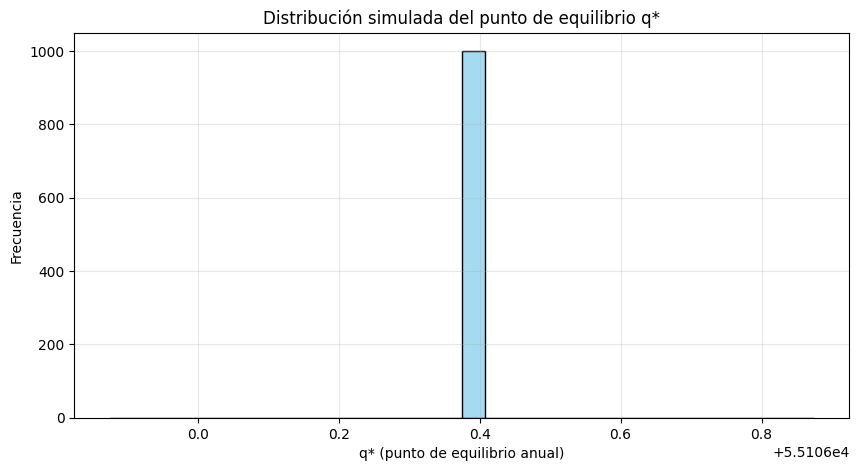

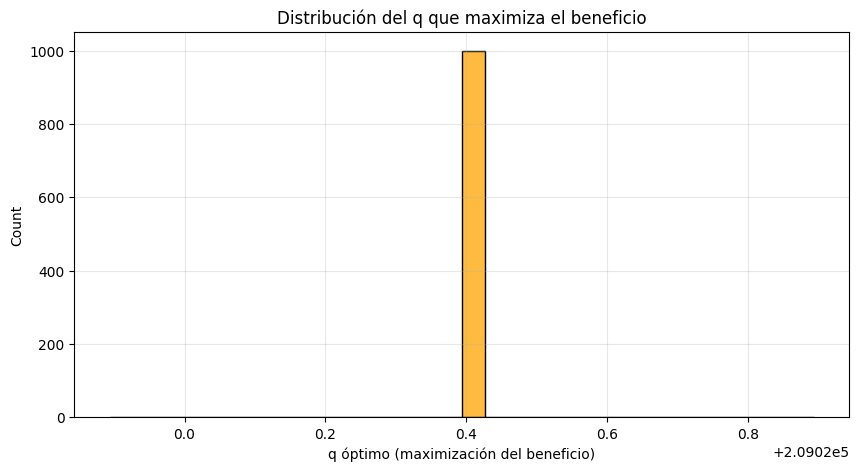

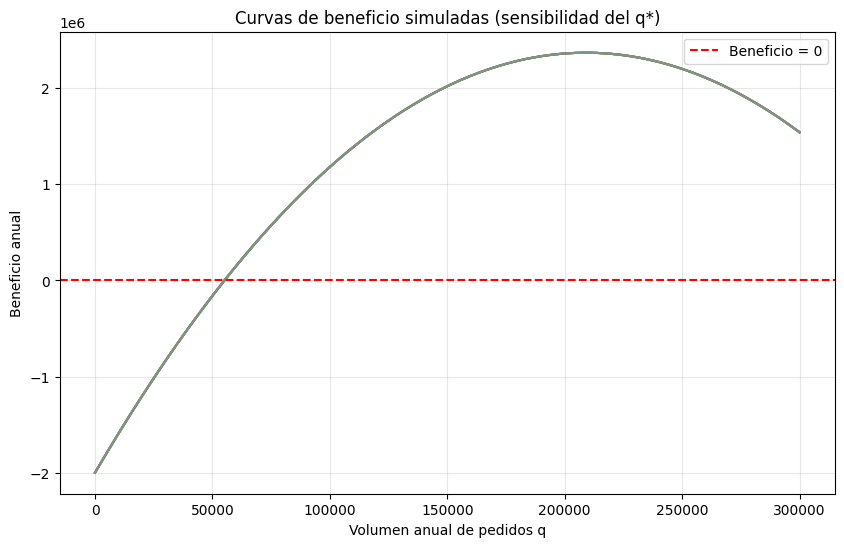

Simulaciones válidas: 1000
Media q*: 55106.374738284125
Mediana q*: 55106.3747382841
P05 q*: 55106.3747382841
P95 q*: 55106.3747382841

--- q óptimo (beneficio máximo) ---
Media: 209020.3936905391
Mediana: 209020.3936905391
P05: 209020.3936905391
P95: 209020.3936905391


In [ ]:
q_stars, q_maxes, curvas = simular_q_star(
    N=1000,
    P_prom = items['price'].mean(),
    Flete_prom = items['freight_value'].mean(),
    Peso_prom = products['product_weight_g'].mean(),
    CF_total=2000000,
    num_curvas=20
)


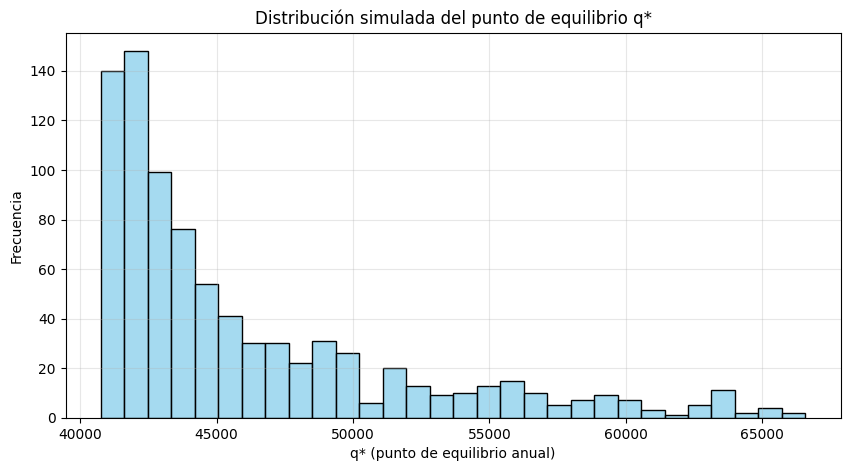

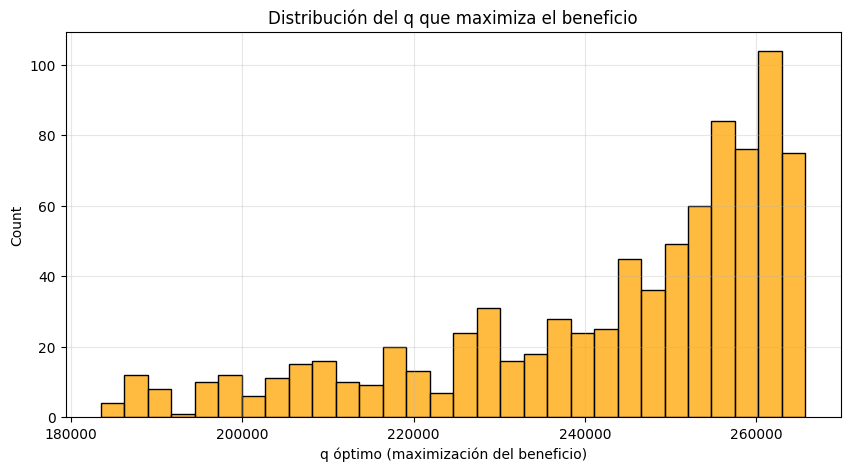

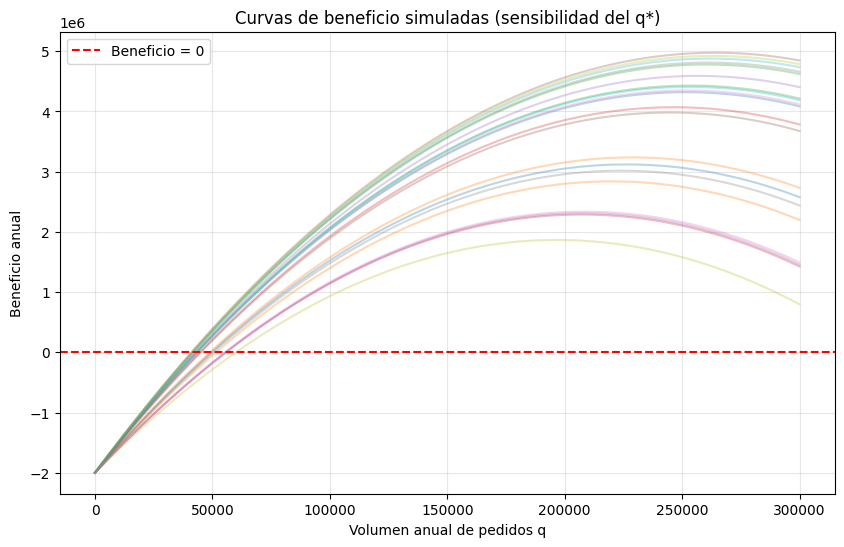

Simulaciones válidas: 849
Media q*: 46039.79821556389
Mediana q*: 43630.117198631524
P05 q*: 41098.26800696964
P95 q*: 58974.77455684111

--- q óptimo (beneficio máximo) ---
Media: 243072.0515189776
Mediana: 251014.53505598338
P05: 199051.42481730517
P95: 263868.391728541


In [ ]:
q_stars, q_maxes, curvas = simular_q_star(
    N=1000,
    P_prom = items['price'].mean(),
    Flete_prom = items['freight_value'].mean(),
    random_weight=True,
    CF_total=2000000,
    num_curvas=20
)


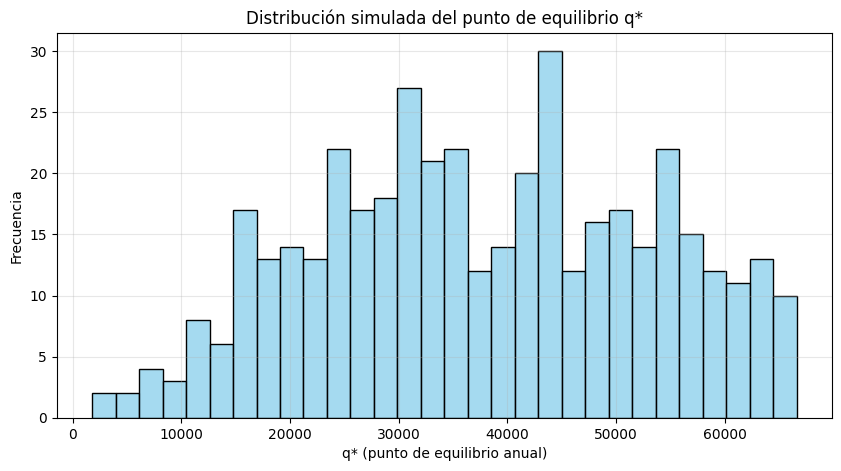

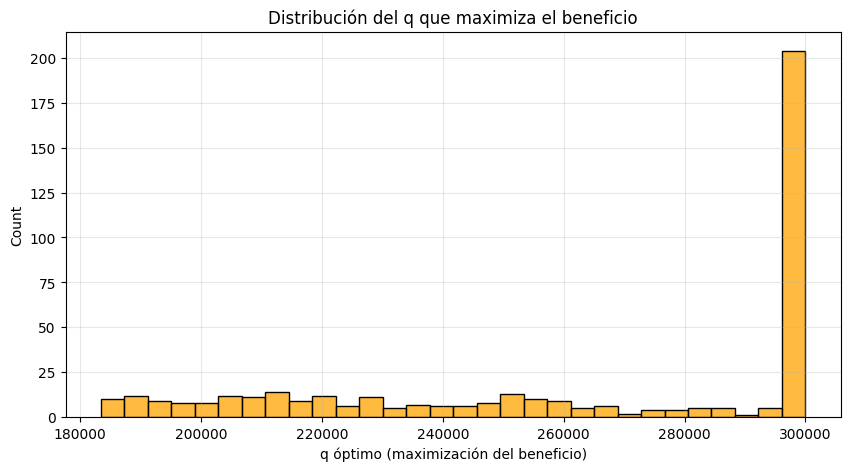

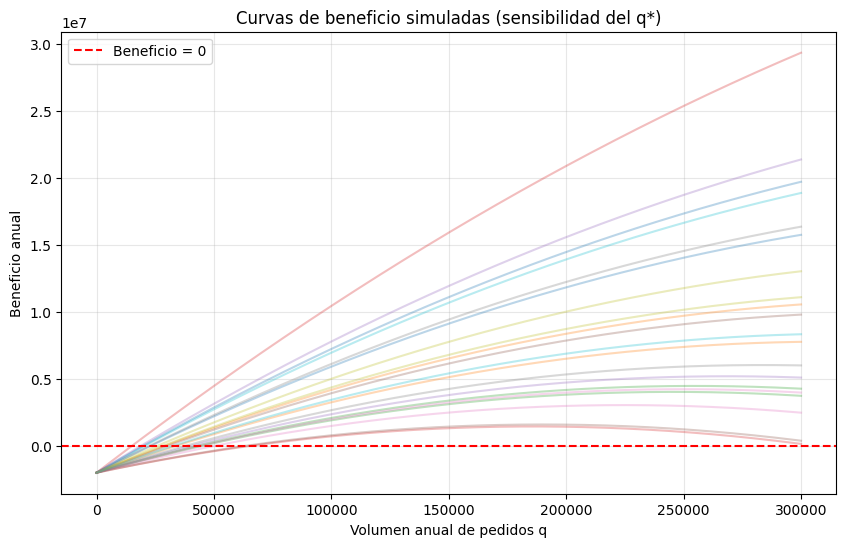

Simulaciones válidas: 427
Media q*: 37812.91023223045
Mediana q*: 37529.573334450106
P05 q*: 13596.416256331451
P95 q*: 62640.17137767495

--- q óptimo (beneficio máximo) ---
Media: 263505.3980017752
Mediana: 285221.31830882083
P05: 190963.48302771308
P95: 299999.99999951944


In [ ]:
q_stars, q_maxes, curvas = simular_q_star(
    N=1000,
    random_price=True,
    random_freight=True,
    random_weight=True,
    CF_total=2000000,
    num_curvas=20
)